## USEFUL PACKAGES

In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import emoji
import re
from itertools import cycle
%matplotlib inline
import seaborn as sns
import plotly.express as px
import warnings
# Para tratamientos de texto
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import spacy
import es_core_news_md
from spellchecker import SpellChecker

# Modelos Scikit-learn
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,HistGradientBoostingClassifier,GradientBoostingClassifier,StackingClassifier

# Evaluacion
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,balanced_accuracy_score,precision_score,f1_score,average_precision_score
from sklearn.metrics import roc_curve,auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay



#---------------------------------------------------------------------------------#
warnings.filterwarnings('ignore')

C:\Users\Blues\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\spacy\util.py:887: UserWarning: [W095] Model 'es_core_news_md' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.5.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
def read_dataset(path):
    tree = ET.parse(path)
    root = tree.getroot()
    value = []
    for sentiment in root.iter('sentiment'):
        for polarity in sentiment.iter('polarity'):
            for deep_tag in polarity:
            #print(deep_tag.text)
                value.append(deep_tag.text)
    df = pd.read_xml(path)
    df['sentiment'] = value
    return df

## Corpus 2018

In [3]:
df_train_2018 = pd.DataFrame()
for filename in os.listdir('../data2018/train/'):
    df_initial_2018 = read_dataset('../data2018/train/'+filename)
    df_train_2018 = pd.concat([df_train_2018,df_initial_2018])
df_train_2018 = df_train_2018[['tweetid', 'content', 'sentiment']]
df_train_2018.columns = ['id', 'tweet', 'classification']

## CORPUS 2019

In [4]:
df_train_2019 = pd.DataFrame()
for filename in os.listdir('../data2019/train/'):
    df_initial_2019 = read_dataset('../data2019/train/'+filename)
    df_train_2019 = pd.concat([df_train_2019,df_initial_2019])
df_train_2019 = df_train_2019[['tweetid', 'content', 'sentiment']]
df_train_2019.columns = ['id', 'tweet', 'classification']

## DATASET 2020

In [5]:
df_initial_1 = pd.DataFrame()
for filename in os.listdir('../data/train/'):
    df_country = pd.read_csv('../data/train/'+ filename, sep='\t', names=['id','tweet','classification'])
    #df_country['fuente'] = filename+'train'
    df_initial_1 = pd.concat([df_initial_1, df_country])
df_initial_2 = pd.DataFrame()
for filename in os.listdir('../data/dev/'):
    df_country = pd.read_csv('../data/dev/'+ filename, sep='\t', names=['id','tweet','classification'])
    #df_country['fuente'] = filename+'dev'
    df_initial_2 = pd.concat([df_initial_2, df_country])

df_initial = pd.concat([df_initial_1,df_initial_2])
df_initial = df_initial.drop_duplicates(subset='id')
df_initial = df_initial.replace({'classification':{'N':-1,'NEU':0,'P':1}})
df_initial.head(1)

,id,tweet,classification
0,809927403615256576,En definitiva! Me quedé sin campo para ir a Ta...,-1


In [6]:
df_final_test = pd.DataFrame()
for filename in os.listdir('../data/test/'):
    df_country_test = pd.read_csv('../data/test/'+ filename, sep='\t', names=['id','tweet'])
    #df_country_test['fuente'] = filename+'test'
    df_final_test = pd.concat([df_final_test, df_country_test])

df_final_sentiment = pd.DataFrame()
for filename in os.listdir('../data/testgold/'):
    df_country_testgold = pd.read_csv('../data/testgold/'+ filename, sep='\t', names=['id','classification'])
    #df_country_testgold['fuente'] = filename+'test'
    df_final_sentiment = pd.concat([df_final_sentiment, df_country_testgold])

df_final = df_final_test.merge(df_final_sentiment, how = 'left', on = 'id')   
df_final = df_final.replace({'classification':{'N':-1,'NEU':0,'P':1}})
df_final = df_final.drop_duplicates(subset='id')


In [7]:
df_final.groupby('classification').count()

,id,tweet
classification,,
-1,2939,2939
0,1966,1966
1,2359,2359


In [8]:
df_final.shape

(7264, 3)

In [9]:
df_initial.groupby('classification').count()

,id,tweet
classification,,
-1,2835,2835
0,2315,2315
1,2093,2093


-1    2835
 0    2315
 1    2093
Name: classification, dtype: int64
Tamaño del dataset: (7243, 3)


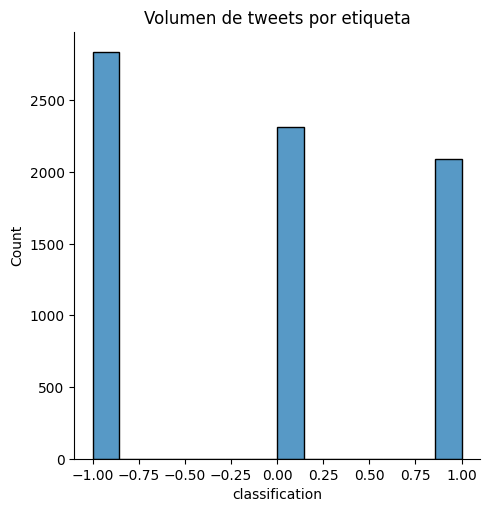

In [10]:
# Comprobamos distribución de la etiqueta 'classification'
sns.displot(df_initial.classification)
plt.title('Volumen de tweets por etiqueta');
print(df_initial.classification.value_counts())
print('Tamaño del dataset:', df_initial.shape)

(0.0, 40.0)

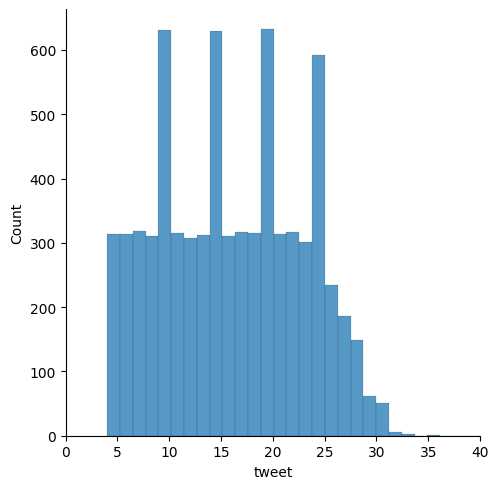

In [11]:
def count_words(df):
    count = 0
    for word in df.split():
        count += 1
    return count
#------------------------------------------------------------------------------------#
## recortar el eje x hasta 100 para mejorar la visualizacion.
ax = sns.displot(df_initial['tweet'].apply(count_words))
plt.xlim(0,40)

### Funciones para tratamiento de datos


* Debemos tener que estos tweets no están normalizados y por lo tanto debemos diseñar funciones que no permitan normalizar las expreciones escritas, quitar, emojis y corregir algunas otras cosas para no tener palabras que aunque signifiquen lo mismo parezcan diferentes.

In [12]:
# Eliminamos signos de puntuación y sustituimos por espacios en blanco

def remove_punctuation_space(df):
    PUNCTUATION = re.compile("""(\-)|(\,)|(\..)|(\...)|(\....)|(\.....)|(\......)|(\.......)""")
    
    return " ".join([PUNCTUATION.sub(" ", word.lower()) for word in df.split()])

In [13]:
# Eliminamos signos de puntuación sin reemplazo

def remove_punctuation(df):
    PUNCTUATION = re.compile("""(\.)|(\;)|(\:)|(\!)|(\?)|(\¡)|(\¿)| \
    (\")|(\()|(\))|(\[)|(\])|(\d+)|(\/)|(\“)|(\”)|(\')|(\-)|(\")|(\*)""")
    
    return " ".join([PUNCTUATION.sub("", word.lower()) for word in df.split()])

In [14]:
# Corregimos abreviaciones
def fix_abbr(x):
    if type(x) == list:
        words = x
    elif type(x) == str:
        words = x.split()
    else:
        raise TypeError('El formato no es válido, debe ser lista o str')

    abbrevs = {'d': 'de',
               'x': 'por',
               'xa': 'para',
               'as': 'has',
               'q': 'que',
               'k': 'que',
               'dl': 'del',
               'xq': 'porqué',
               'dr': 'doctor',
               'dra': 'doctora',
               'sr': 'señor',
               'sra': 'señora',
               'm': 'me'}
    return " ".join([abbrevs[word] if word in abbrevs.keys() else word for word in words])

In [15]:

# Sustituimos links por {link}
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

In [16]:
# Eliminamos vocales repetidas
    
def remove_repeated_vocals(df):
    
    list_new_word = []

    for word in df.split(): #separamos en palabras
        new_word = []
        pos = 0
        
        for letra in word: #separamos cada palabra en letras
            #print(word, letra, pos, '-', new_word)
            if pos>0:
                if letra in ('a', 'e', 'i', 'o', 'u') and letra == new_word[pos-1]:
                    None
                else:
                    new_word.append(letra)
                    pos +=1
            else:
                new_word.append(letra)
            
                pos += 1
        else:
            list_new_word.append("".join(new_word))
                
    return " ".join(list_new_word)

In [17]:
# Normalizamos risas 'jajaja', 'jejeje', 'jojojo'
    
def normalize_laughts(df):
    
    list_new_words = []
    for word in df.split(): #separamos en palabras
        count = 0
        vocals_dicc = {'a': 0, 'e': 0, 'i': 0, 'o':0, 'u':0}
        
        for letra in word:
            #print(word)
            if letra == 'j':
                count+=1
            if letra in vocals_dicc.keys():
                vocals_dicc[letra] += 1
        else:
            if count>3:
                dicc_risa = {'a': 'jaja', 'e': 'jeje', 'i': 'jiji', 'o': 'jojo', 'u': 'juju'}
                risa_type = max(vocals_dicc, key= lambda x: vocals_dicc[x]) #Indica si es a,e,i,o,u
                list_new_words.append(dicc_risa[risa_type])
            else:
                list_new_words.append(word)
    
    return " ".join(list_new_words)

In [18]:
# Sustituimos hashtag por {hash}
def remove_hashtags(df):
    return " ".join(['{hash}' if word.startswith('#') else word for word in df.split()])

In [19]:
# Sustituimos menciones por {mencion}
def remove_mentions(df):
    return " ".join(['{menc}' if word.startswith('“@') or word.startswith('@') else word for word in df.split()])

In [20]:
# Función para identificar los 'emojis' tradicionales

def transform_icons(df):
    word_list = []
    pos_emojis = [':)', ':D', ':))', ':)))', 'xD', 'xd', 'XD']
    neg_emojis = [':(', ":'(", '>:(', ':,(', ":(("]
    for word in df.split():
        if word in neg_emojis:
            word = '{emoji_neg}'
            word_list.append(word)
        elif word in pos_emojis:
            word = '{emoji_pos}'
            word_list.append(word)
        elif ':O' in word:
            word = '{emoji_neu}'
            word_list.append(word)
        else:
            word_list.append(word)
    return " ".join(word_list)

In [21]:
# Separamos emojis que vengan juntos
def Seprsep_emojis(df):
    words_list = []
    for token in df.split():
        new_word = []
        for letra in token:
            if letra in emoji.UNICODE_EMOJI['es']:
                words_list.append(letra)
            else:
                new_word.append(letra)
        else:
            words_list.append("".join(new_word))

    return (" ".join(word for word in words_list if word != ''))

In [22]:
# Eliminamos stopwords
nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')
non_stopwords = ['no', 'ni', 'poco', 'mucho', 'nada', 'muchos', 'muy', 'nosotros',
                 'nosotras', 'vosotros', 'vosotras', 'ellos', 'ellas', 'ella', 'él', 'tu', 'tú', 'yo',
                 'pero', 'hasta', 'contra', 'por']
spanish_stopwords = [word for word in stopwords.words('spanish') if word not in non_stopwords]

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Blues\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Función para stemizar
def stem(df):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in df.split()])

In [24]:
# Función para lematizar
# Creamos el objeto
spacy.prefer_gpu() # or spacy.require_gpu()
nlp = spacy.load("es_core_news_md")


# Definimos función
def lemmatizer(df):
    word_list = []
    doc = nlp(df)
    for tok in doc:
        if str(tok) == 'menc':
              word_list.append('{menc}')
        elif str(tok) == 'hash':
              word_list.append('{hash}')
        elif str(tok) == 'link':
              word_list.append('{link}')
        elif str(tok) == 'emoji_pos':
              word_list.append('{emoji_pos}')
        elif str(tok) == 'emoji_neu':
              word_list.append('{emoji_neu}')
        elif str(tok) == 'emoji_neg':
              word_list.append('{emoji_neg}')
        elif str(tok) == 'eur':
              word_list.append('{eur}')
        else:
            word_list.append(tok.lemma_.lower())

    return " ".join([word for word in word_list if (word != '{') and (word!='}')])  

In [25]:
# Función para corregir las palabras

spell = SpellChecker(language='es', distance=1)

def correcting_words(df):
    misspelled = spell.unknown(df.split())
    return " ".join(filter(None,[spell.correction(word) if word in misspelled else word for word in df.split()]))

In [26]:
def remove_eur(df):
    wlist = ['{eur}' if ('€' in word) | ('euro' in word) | ('$' in word) else word for word in df.split()]
    return " ".join(wlist)

In [27]:
# Put it all together

def transform_tweets(df, mode='lemma'):
    
    df = remove_links(df)
    df = remove_punctuation_space(df)
    df = remove_mentions(df)    
    df = remove_hashtags(df)
    df = remove_eur(df)
    df = transform_icons(df)
    df = sep_emojis(df)
   # df = transform_emoji(df)
    df = normalize_laughts(df)
    df = remove_punctuation(df)
    df = remove_repeated_vocals(df)
    df = correcting_words(df)
    df = fix_abbr(df)
    df = remove_stopwords(df)
    if mode=='lemma':
        df = lemmatizer(df)
    elif mode=='stem':
        df = stem(df)
    else:
        raise TypeError('Invalid mode. Must be "lemma" or "stem"') 
    df = remove_stopwords(df)                    
    return df

El stemizado es mejor para usar en ingles, es mejor el lemetizado para lenguas romance

In [28]:
print('Tweet original:\n', df_initial.tweet[50:51].iloc[0])
print('Tweet lematizado:\n', df_initial.tweet[50:51].apply(transform_tweets, mode='lemma').iloc[0])
print('Tweet stemizado:\n',df_initial.tweet[50:51].apply(transform_tweets, mode='stem').iloc[0])

Tweet original:
 Nos encanta hacerte feliz @rubndu
Tweet lematizado:
 encantar hacerte feliz
Tweet stemizado:
 encant hacert feliz


In [29]:
%%time
# Aplicamos
df_initial['tweet_'] = df_initial.tweet.apply(transform_tweets, mode='lemma')
df_final['tweet_'] = df_final.tweet.apply(transform_tweets, mode='lemma')

CPU times: total: 3min 28s
Wall time: 3min 37s


# Modelos 

In [196]:
X_train, y_train = df_initial['tweet_'], df_initial['classification']
X_test, y_test = df_final['tweet_'], df_final['classification']
y_test_binarize = label_binarize(y_test,classes=[-1,0,1])
# Vectorizamos
from sklearn.feature_extraction.text import CountVectorizer

# Creamos objeto y entrenamos
df_vectorizer = CountVectorizer(binary = True,
                                      ngram_range=(1, 3))
df_vectorizer.fit(X_train)

# Transformamos X en sparse vector
X_train_vec = df_vectorizer.transform(X_train)
X_test_vec = df_vectorizer.transform(X_test)

## Algoritmos Clásicos de clasificación

### Regresión Logistica

1 los dableje en luga5 de 5 10
2 un rango mas amplio para el parametro C de a 1 a 10 
si tenemos un mensaje de no convergencia tenemo que ponemos mas iteraciones
cambiar el scoring por f1 

In [197]:
clf_LR = LogisticRegression(C = 1.5 , class_weight = None, penalty = 'l2', solver ='newton-cg', random_state=0).fit(X_train_vec, y_train)
y_pred_log_reg_cv_proba = clf_LR.predict_proba(X_test_vec)
y_pred_log_reg_cv = clf_LR.predict(X_test_vec)

comparacion entre predict_proba y el predic para revisar la si hay cambios significantes en los resultados.

In [198]:
def get_label(probas, i=0.55):
    if np.argmax(probas)==0:
        return -1
    elif np.argmax(probas)==2:
        return 1
    elif np.argmax(probas)==1 and probas[1]<i:
        if probas[2] > probas[0]:
            return 1
        else:
            return -1
    else:
        return 0

y_new = np.array(list(map(lambda x: get_label(x), y_pred_log_reg_cv_proba)))

def interact_proba(i):
    plt.clf()
    
    y_new = np.array(list(map(lambda x: get_label(x, i), y_pred_log_reg_cv_proba)))
    
    # Evaluamos modelo
    sns.heatmap(confusion_matrix(y_test, y_new, normalize = 'true'),
                annot=True, fmt='g', cmap = 'Blues', cbar = False);

    plt.title("""Accuracy para cada clase en función
    del threshold controlado por el parámetro i""")
    plt.xlabel('Predicted values')
    plt.ylabel('Real values');

    plt.show()

In [199]:
np.unique(y_new)

array([-1,  0,  1])

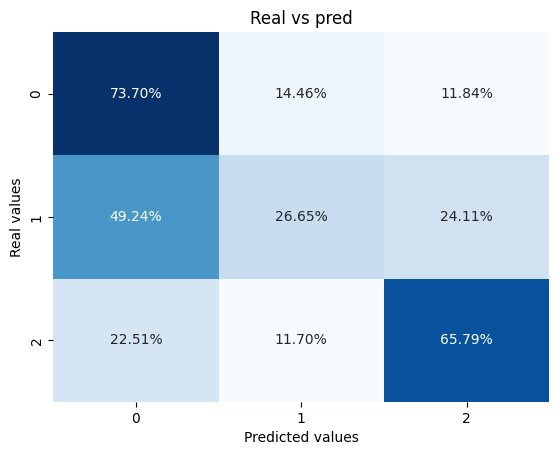

In [200]:
# Evaluamos modelo
sns.heatmap(confusion_matrix(y_test, y_new, normalize = 'true'),
            annot=True,fmt='.2%', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

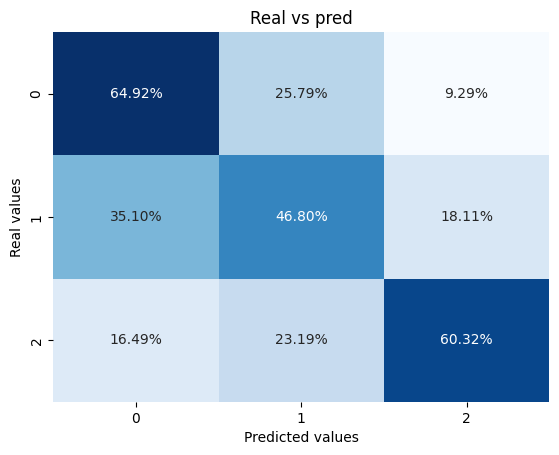

In [201]:
# Evaluamos modelo
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg_cv, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

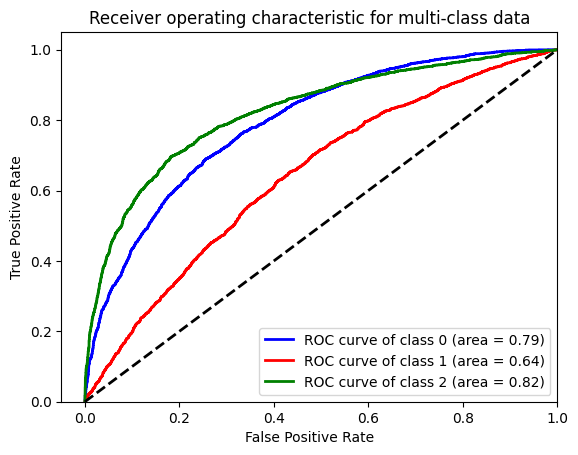

In [202]:
# Compute ROC curve and ROC area for each class
n_classes = 3
y_score = clf_LR.decision_function(X_test_vec)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [203]:
ct_lr = ['regresion_logistica','CountVectorizer',accuracy_score(y_test, y_pred_log_reg_cv),f1_score(y_test, y_pred_log_reg_cv, average='macro'),
         precision_score(y_test, y_pred_log_reg_cv,average='macro'),balanced_accuracy_score(y_test, y_pred_log_reg_cv),
         roc_auc_score(y_test, clf_LR.predict_proba(X_test_vec),multi_class='ovr')]
ct_lr

['regresion_logistica',
 'CountVectorizer',
 0.5852147577092511,
 0.5760610497362562,
 0.5819069754286398,
 0.5734591171593816,
 0.7582897377858783]

In [204]:
# Sacamos matriz de correlación
print(classification_report(y_test, y_pred_log_reg_cv))

              precision    recall  f1-score   support

          -1       0.64      0.65      0.64      2939
           0       0.41      0.47      0.44      1966
           1       0.69      0.60      0.65      2359

    accuracy                           0.59      7264
   macro avg       0.58      0.57      0.58      7264
weighted avg       0.60      0.59      0.59      7264



### SVC

In [205]:
pipe_lin_svc = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('svc', LinearSVC())
])
pipe_lin_svc_params = dict(svc__C = [0.01, 0.1, 0.25, 0.5, 1, 1.5])

lin_svc_cv = GridSearchCV(pipe_lin_svc,
                          pipe_lin_svc_params,
                          cv = 10,
                          n_jobs = -1,
                          scoring = 'f1')
lin_svc_cv.fit(X_train_vec, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('svc', LinearSVC())]),
             n_jobs=-1, param_grid={'svc__C': [0.01, 0.1, 0.25, 0.5, 1, 1.5]},
             scoring='f1')

In [206]:
lin_svc_cv.best_params_

{'svc__C': 0.01}

In [207]:
# Predecimos

y_pred_lin_svc_cv = lin_svc_cv.predict(X_test_vec)
accuracy_lin_svc_cv = accuracy_score(y_test, y_pred_lin_svc_cv)
accuracy_lin_svc_cv

0.5088105726872246

In [208]:
ct_svc_lineal = ['scv_lineal','CountVectorizer',accuracy_score(y_test, y_pred_lin_svc_cv), f1_score(y_test, y_pred_lin_svc_cv, average='macro'),
          precision_score(y_test, y_pred_lin_svc_cv,average='macro'),balanced_accuracy_score(y_test, y_pred_lin_svc_cv),
          0]
ct_svc_lineal

['scv_lineal',
 'CountVectorizer',
 0.5088105726872246,
 0.5080345606415225,
 0.5245827058981943,
 0.50682720002851,
 0]

In [209]:
# Sacamos matriz de correlación
print(classification_report(y_test, y_pred_lin_svc_cv))

              precision    recall  f1-score   support

          -1       0.57      0.53      0.55      2939
           0       0.36      0.50      0.42      1966
           1       0.64      0.49      0.56      2359

    accuracy                           0.51      7264
   macro avg       0.52      0.51      0.51      7264
weighted avg       0.54      0.51      0.52      7264



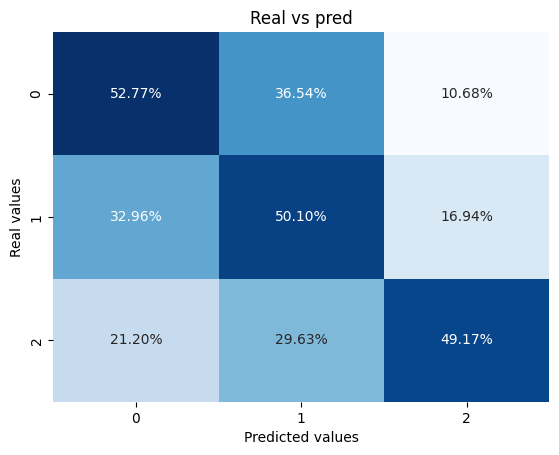

In [210]:
#display_cm(y_test, y_pred_rf_cv)

sns.heatmap(confusion_matrix(y_test,y_pred_lin_svc_cv, normalize = 'true'),
            annot=True,fmt='.2%' ,cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

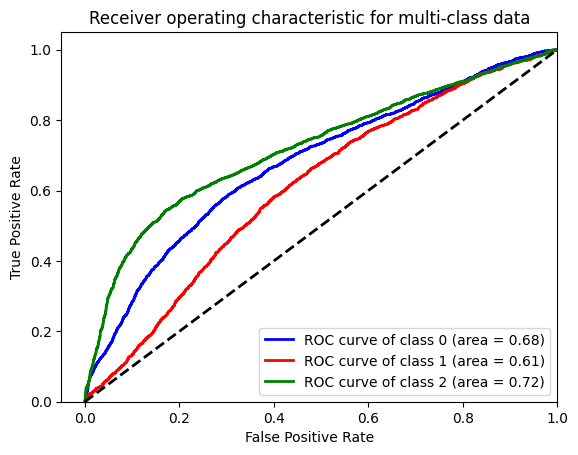

In [211]:
n_classes = 3
y_score = lin_svc_cv.decision_function(X_test_vec)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### GaussianNB

In [212]:
clf_GN = GaussianNB()
clf_GN.fit(X_train_vec.toarray(), y_train)
y_pred_clf_GN = clf_GN.predict(X_test_vec.toarray())

In [213]:
print(classification_report(y_test,y_pred_clf_GN))

              precision    recall  f1-score   support

          -1       0.55      0.36      0.43      2939
           0       0.30      0.32      0.31      1966
           1       0.44      0.61      0.51      2359

    accuracy                           0.43      7264
   macro avg       0.43      0.43      0.42      7264
weighted avg       0.45      0.43      0.43      7264



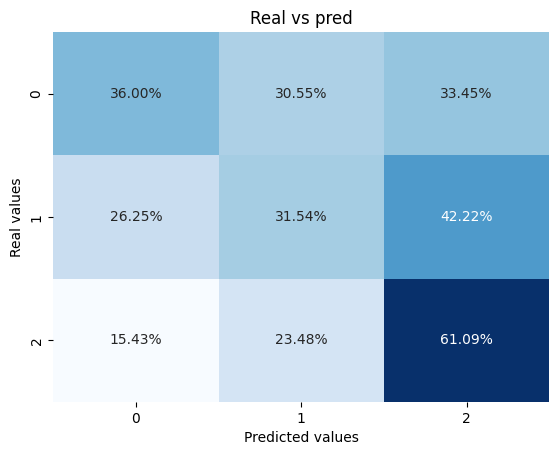

In [214]:
sns.heatmap(confusion_matrix(y_test, y_pred_clf_GN, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
plt.show()

In [215]:
ct_GauNB = ['GaussianNB','CountVectorizer',accuracy_score(y_test, y_pred_clf_GN), f1_score(y_test, y_pred_clf_GN, average='macro'),
            precision_score(y_test, y_pred_clf_GN,average='macro'),balanced_accuracy_score(y_test, y_pred_clf_GN),
            roc_auc_score(y_test,clf_GN.predict_proba(X_test_vec.toarray()),multi_class='ovr')]
ct_GauNB

['GaussianNB',
 'CountVectorizer',
 0.42937775330396477,
 0.4181356381612223,
 0.4293303379638654,
 0.4287331950845794,
 0.5731738096923372]

# Otro algoritmos de clasificación

Metodo de ensamble 

Gradient boosting
knn 
Bayes Gaussiano. 


Cuando utilicemos otras arquitecturas debemos cambiar las medidas


## Métodos de Ensamble

### Random Forest

Barrido de n_estimator = 100 hasta 400 aumentos de 50 
max_depth ---> 2,10 incremtos de 2
min_samples_leaf ----1,2,3
criterion ----> “gini”, “entropy”
class_weight--> “balanced”, “balanced_subsample []

In [216]:
random_forest_cv = RandomForestClassifier(class_weight= 'balanced_subsample',
 criterion= 'entropy',
 max_depth= 10,
 min_samples_leaf= 1,
 n_estimators= 350,random_state= 123)
random_forest_cv.fit(X_train_vec, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, n_estimators=350, random_state=123)

In [217]:
y_pred_rf_cv = random_forest_cv.predict(X_test_vec)
print(classification_report(y_test, y_pred_rf_cv))

              precision    recall  f1-score   support

          -1       0.64      0.63      0.63      2939
           0       0.41      0.46      0.43      1966
           1       0.68      0.62      0.65      2359

    accuracy                           0.58      7264
   macro avg       0.58      0.57      0.57      7264
weighted avg       0.59      0.58      0.59      7264



In [218]:
ct_rf = ['RandomForest','CountVectorizer',accuracy_score(y_test, y_pred_rf_cv),f1_score(y_test, y_pred_rf_cv, average='macro'),
         precision_score(y_test, y_pred_rf_cv,average='macro'),balanced_accuracy_score(y_test, y_pred_rf_cv),
         roc_auc_score(y_test, random_forest_cv.predict_proba(X_test_vec),multi_class='ovr')]
ct_rf

['RandomForest',
 'CountVectorizer',
 0.5820484581497798,
 0.5735858862881713,
 0.5774921843140596,
 0.5717678581715996,
 0.7468918156389709]

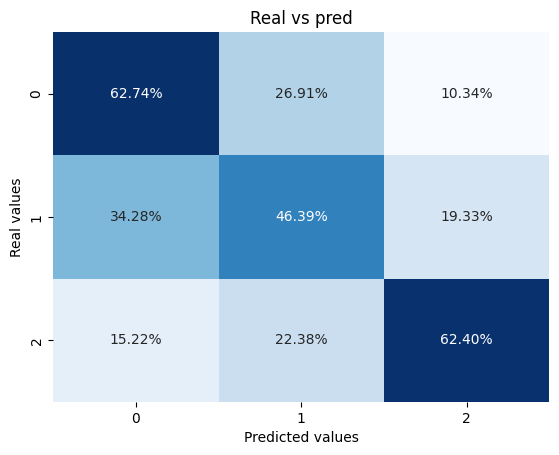

In [219]:
y_pred_rf_cv = random_forest_cv.predict(X_test_vec)
sns.heatmap(confusion_matrix(y_test, y_pred_rf_cv, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
plt.show()

## HistGradientBoostingClassifier

In [220]:
clf_hgb = HistGradientBoostingClassifier()
clf_hgb.fit(X_train_vec.toarray(), y_train)
y_pred_clf_hgb = clf_hgb.predict(X_test_vec.toarray())

In [221]:
print(classification_report(y_test, y_pred_clf_hgb))

              precision    recall  f1-score   support

          -1       0.61      0.62      0.61      2939
           0       0.39      0.46      0.43      1966
           1       0.69      0.57      0.63      2359

    accuracy                           0.56      7264
   macro avg       0.56      0.55      0.56      7264
weighted avg       0.58      0.56      0.57      7264



In [222]:
ct_HBG = ['HistGradientBoostingClassifier','CountVectorizer',accuracy_score(y_test, y_pred_clf_hgb),f1_score(y_test, y_pred_clf_hgb, average='macro')
          ,precision_score(y_test, y_pred_clf_hgb,average='macro'),balanced_accuracy_score(y_test, y_pred_clf_hgb),
          roc_auc_score(y_test,clf_hgb.predict_proba(X_test_vec.toarray()),multi_class= 'ovr')] 
ct_HBG

['HistGradientBoostingClassifier',
 'CountVectorizer',
 0.5618116740088106,
 0.5550031178684373,
 0.5634825208333863,
 0.5518046651253088,
 0.7391636546913706]

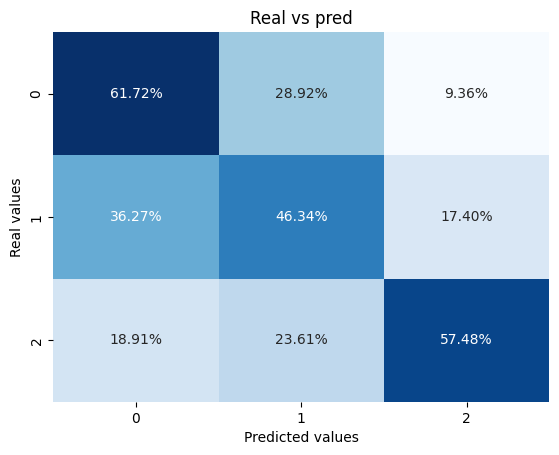

In [223]:
sns.heatmap(confusion_matrix(y_test,y_pred_clf_hgb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

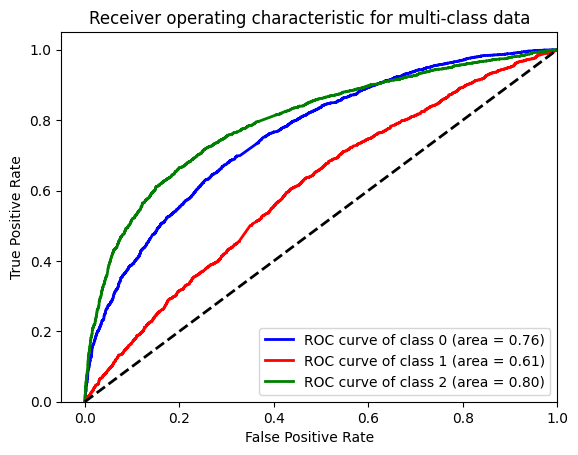

In [224]:
n_classes = 3
y_score = clf_hgb.decision_function(X_test_vec.toarray())
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


### GradientBoostingClassifier

In [225]:
clf_GBC = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train_vec, y_train)
y_predict_clf_GBC = clf_GBC.predict(X_test_vec)

In [226]:
print(classification_report(y_test, y_predict_clf_GBC))

              precision    recall  f1-score   support

          -1       0.64      0.59      0.61      2939
           0       0.39      0.53      0.45      1966
           1       0.70      0.57      0.63      2359

    accuracy                           0.57      7264
   macro avg       0.58      0.56      0.56      7264
weighted avg       0.59      0.57      0.57      7264



In [227]:
ct_GBc = ['GradientBoostingClassifier','CountVectorizer',accuracy_score(y_test,y_predict_clf_GBC),
          f1_score(y_test, y_predict_clf_GBC, average='macro'),precision_score(y_test, y_predict_clf_GBC,average='macro'),
          balanced_accuracy_score(y_test, y_predict_clf_GBC),roc_auc_score(y_test,clf_GBC.predict_proba(X_test_vec),multi_class='ovr')]
ct_GBc

['GradientBoostingClassifier',
 'CountVectorizer',
 0.5652533039647577,
 0.5636023292193814,
 0.5779836546049935,
 0.5616587276996899,
 0.7384069788514559]

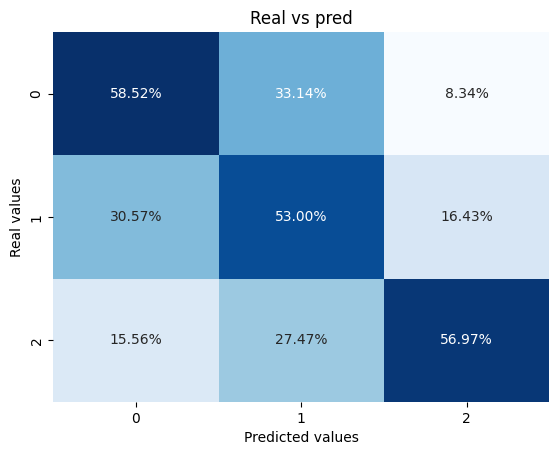

In [228]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_GBC, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

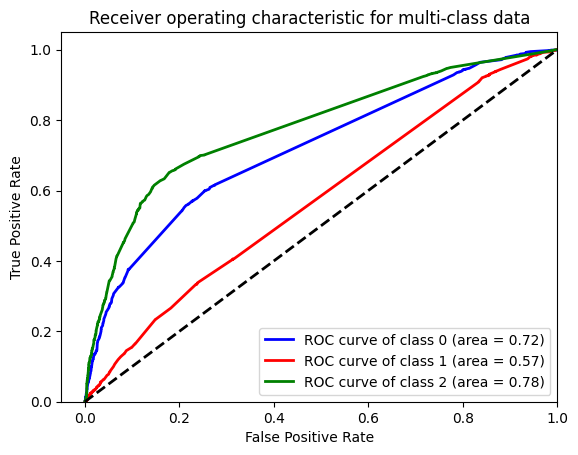

In [229]:
n_classes = 3
y_score = clf_GBC.decision_function(X_test_vec.toarray())
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


### VotingClassifier

In [230]:
eclf2 = VotingClassifier(estimators=[
         ('lr', clf_LR ), ('rf', random_forest_cv ), ('GBC', clf_GBC),('HB', clf_hgb)],
         voting='soft')
eclf2 = eclf2.fit(X_train_vec.toarray(), y_train)
y_predict_clf_VT= eclf2.predict(X_test_vec.toarray())

In [231]:
try:
 ct_VC = ['VotingClassifier','CountVectorizer',accuracy_score(y_test,y_predict_clf_VT),f1_score(y_test,y_predict_clf_VT,average='macro')
         ,precision_score(y_test,y_predict_clf_VT,average='macro'),balanced_accuracy_score(y_test,y_predict_clf_VT),
         roc_auc_score(y_test,eclf2.predict_proba(X_test_vec.toarray()),multi_class='ovr')]
except :
  ct_VC = ['VotingClassifier','CountVectorizer',accuracy_score(y_test,y_predict_clf_VT),f1_score(y_test,y_predict_clf_VT,average='macro')
         ,precision_score(y_test,y_predict_clf_VT,average='macro'),balanced_accuracy_score(y_test,y_predict_clf_VT),
        0]

ct_VC

['VotingClassifier',
 'CountVectorizer',
 0.5821861233480177,
 0.5725669890766261,
 0.5785649823259447,
 0.569558119488767,
 0.7627787624312171]

In [232]:
print(classification_report(y_test, y_predict_clf_VT))

              precision    recall  f1-score   support

          -1       0.63      0.65      0.64      2939
           0       0.41      0.45      0.43      1966
           1       0.70      0.61      0.65      2359

    accuracy                           0.58      7264
   macro avg       0.58      0.57      0.57      7264
weighted avg       0.59      0.58      0.59      7264



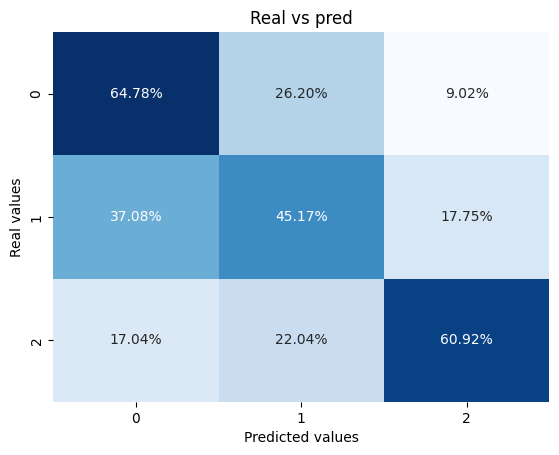

In [233]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_VT, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

### StackingClassifier

In [234]:
estimators = [('lr', LogisticRegression(C = 1.5 , class_weight = None, penalty = 'l2', solver ='newton-cg', random_state=0)),
('rf', RandomForestClassifier(class_weight= 'balanced_subsample',criterion= 'entropy', max_depth= 10, min_samples_leaf= 1, n_estimators= 350,random_state= 123)),
('GB',GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0))]
clf_SC = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [235]:
clf_SC.fit(X_train_vec, y_train)
y_predict_clf_SC= clf_SC.predict(X_test_vec)

In [236]:
print(classification_report(y_test, y_predict_clf_SC))

              precision    recall  f1-score   support

          -1       0.64      0.68      0.66      2939
           0       0.42      0.44      0.43      1966
           1       0.70      0.62      0.65      2359

    accuracy                           0.59      7264
   macro avg       0.58      0.58      0.58      7264
weighted avg       0.60      0.59      0.59      7264



In [237]:
ct_StC = ['StackingClassifier','CountVectorizer',accuracy_score(y_test, y_predict_clf_SC),f1_score(y_test, y_predict_clf_SC,average='macro'),
          precision_score(y_test, y_predict_clf_SC,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_SC),
          roc_auc_score(y_test, clf_SC.predict_proba(X_test_vec),multi_class='ovr')]
ct_StC

['StackingClassifier',
 'CountVectorizer',
 0.5915473568281938,
 0.5787977869235729,
 0.5838345448093575,
 0.5761170879078419,
 0.7674477541385345]

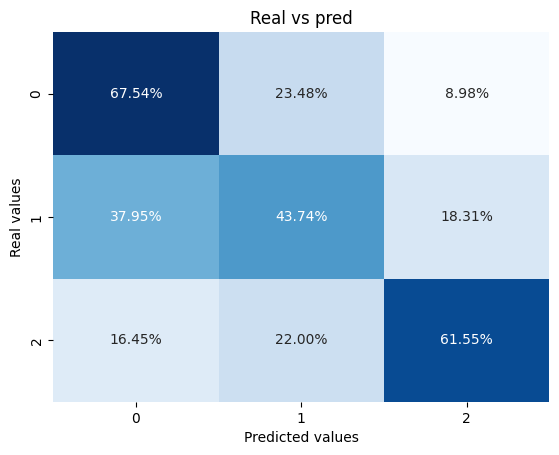

In [238]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_SC, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

### XGrandientBoosting

In [239]:
import xgboost as xgb

In [240]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_xgbr = le.fit_transform(y_train)
y_test_xgbr =le.fit_transform(y_test)

In [241]:
xgbr_clf = xgb.XGBClassifier(booster = 'dart', eta = 0.5, gamma = 0.9 , learning_rate= 0.1,seed = 20)
xgbr_clf.fit(X_train_vec, y_train_xgbr)
y_clf_xgbr = xgbr_clf.predict(X_test_vec)

In [242]:
print(classification_report(y_test_xgbr, y_clf_xgbr))

              precision    recall  f1-score   support

           0       0.55      0.75      0.63      2939
           1       0.39      0.31      0.34      1966
           2       0.73      0.53      0.62      2359

    accuracy                           0.56      7264
   macro avg       0.56      0.53      0.53      7264
weighted avg       0.56      0.56      0.55      7264



In [243]:
ct_Xgbrt = ['XGBClassifier','CountVectorizer',accuracy_score(y_test_xgbr, y_clf_xgbr),f1_score(y_test_xgbr, y_clf_xgbr,average='macro'),
          precision_score(y_test_xgbr, y_clf_xgbr,average='macro'),balanced_accuracy_score(y_test_xgbr, y_clf_xgbr),
          roc_auc_score(y_test_xgbr, xgbr_clf.predict_proba(X_test_vec),multi_class='ovr')]
ct_Xgbrt

['XGBClassifier',
 'CountVectorizer',
 0.5579570484581498,
 0.5305551115926019,
 0.5561386417647982,
 0.5285228841743591,
 0.7415955314463493]

# Otro metodo de vectorizacion

In [244]:
# X_train, y_train = df_initial['tweet_'], df_initial['classification']
# X_test, y_test = df_final['tweet_'], df_final['classification']
# y_test_binarize = label_binarize(y_test,classes=[-1,0,1])
# Vectorizamos
from sklearn.feature_extraction.text import TfidfVectorizer

# Creamos objeto y entrenamos
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

# Transformamos X en sparse vector
X_train_vec_tf = vectorizer.transform(X_train)
X_test_vec_tf = vectorizer.transform(X_test)

## Algoritmos Clásicos de clasificación

### Regresión Logistica

In [245]:
clf_LR_tf = LogisticRegression(C = 0.25 , class_weight = None, penalty = 'l2', solver ='newton-cg', random_state=0).fit(X_train_vec_tf, y_train)
y_pred_log_reg_cv_proba_tf = clf_LR_tf.predict_proba(X_test_vec_tf)
y_pred_log_reg_cv_tf = clf_LR_tf.predict(X_test_vec_tf)

comparacion entre predict_proba y el predic para revisar la si hay cambios significantes en los resultados.

In [246]:
def get_label(probas, i=0.55):
    if np.argmax(probas)==0:
        return -1
    elif np.argmax(probas)==2:
        return 1
    elif np.argmax(probas)==1 and probas[1]<i:
        if probas[2] > probas[0]:
            return 1
        else:
            return -1
    else:
        return 0

y_new = np.array(list(map(lambda x: get_label(x), y_pred_log_reg_cv_proba)))

def interact_proba(i):
    plt.clf()
    
    y_new = np.array(list(map(lambda x: get_label(x, i), y_pred_log_reg_cv_proba)))
    
    # Evaluamos modelo
    sns.heatmap(confusion_matrix(y_test, y_new, normalize = 'true'),
                annot=True, fmt='g', cmap = 'Blues', cbar = False);

    plt.title("""Accuracy para cada clase en función
    del threshold controlado por el parámetro i""")
    plt.xlabel('Predicted values')
    plt.ylabel('Real values');

    plt.show()

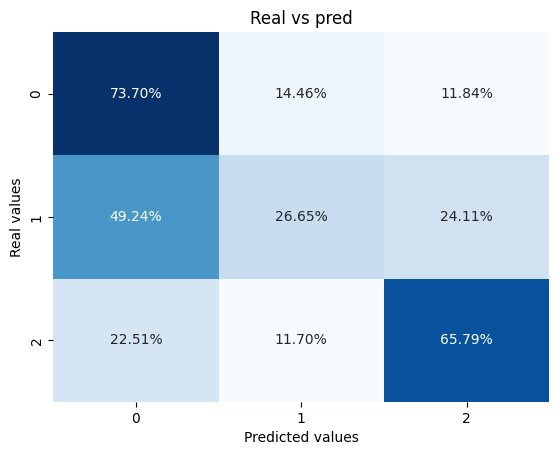

In [247]:
# Evaluamos modelo
sns.heatmap(confusion_matrix(y_test, y_new, normalize = 'true'),
            annot=True,fmt='.2%', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

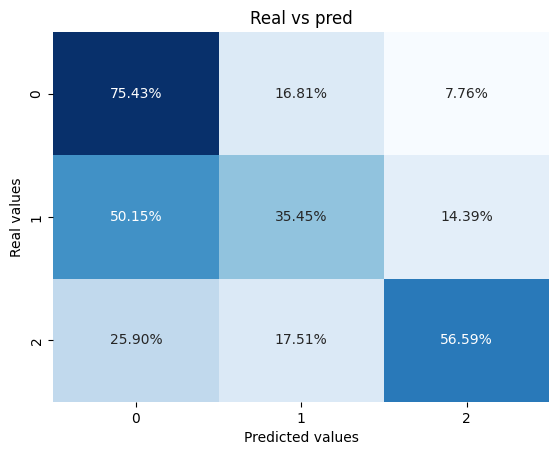

In [248]:
# Evaluamos modelo
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg_cv_tf, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

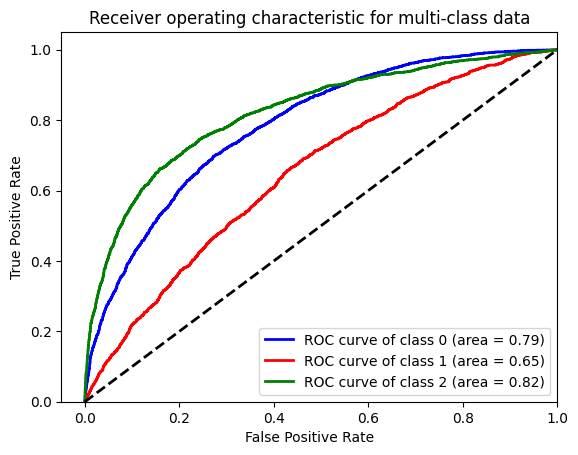

In [249]:
# Compute ROC curve and ROC area for each class
n_classes = 3
y_score = clf_LR_tf.decision_function(X_test_vec_tf)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [250]:
print(classification_report(y_test,y_pred_log_reg_cv_tf))

              precision    recall  f1-score   support

          -1       0.58      0.75      0.66      2939
           0       0.43      0.35      0.39      1966
           1       0.72      0.57      0.63      2359

    accuracy                           0.58      7264
   macro avg       0.58      0.56      0.56      7264
weighted avg       0.59      0.58      0.58      7264



In [251]:
tfc_lr = ['LogisticRegression','TfidfVectorizer',accuracy_score(y_test, y_pred_log_reg_cv_tf),
          f1_score(y_test, y_pred_log_reg_cv_tf,average='macro'),precision_score(y_test, y_pred_log_reg_cv_tf,average='macro'),
          balanced_accuracy_score(y_test, y_pred_log_reg_cv_tf),roc_auc_score(y_test,clf_LR_tf.predict_proba(X_test_vec_tf),multi_class='ovr')]
tfc_lr

['LogisticRegression',
 'TfidfVectorizer',
 0.5849394273127754,
 0.560677213774503,
 0.5796678051322917,
 0.5582609767766696,
 0.7574934981014305]

### SVC

In [252]:
pipe_lin_svc = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('svc', LinearSVC())
])
pipe_lin_svc_params = dict(svc__C = [0.01, 0.1, 0.25, 0.5, 1, 1.5])

lin_svc_cv_tf = GridSearchCV(pipe_lin_svc,
                          pipe_lin_svc_params,
                          cv = 10,
                          n_jobs = -1,
                          scoring = 'f1')
lin_svc_cv_tf.fit(X_train_vec_tf, y_train)
lin_svc_cv_tf.best_params_
y_pred_lin_svc_cv_tf = lin_svc_cv_tf.predict(X_test_vec_tf)


In [253]:
tfc_scv_lineal = ['LinearSVC','TfidfVectorizer',accuracy_score(y_test, y_pred_lin_svc_cv),f1_score(y_test, y_pred_lin_svc_cv,average='macro'),
                  precision_score(y_test, y_pred_lin_svc_cv,average='macro'),balanced_accuracy_score(y_test, y_pred_lin_svc_cv),
                  0]
tfc_scv_lineal

['LinearSVC',
 'TfidfVectorizer',
 0.5088105726872246,
 0.5080345606415225,
 0.5245827058981943,
 0.50682720002851,
 0]

In [254]:
# Sacamos matriz de correlación
print(classification_report(y_test, y_pred_lin_svc_cv))

              precision    recall  f1-score   support

          -1       0.57      0.53      0.55      2939
           0       0.36      0.50      0.42      1966
           1       0.64      0.49      0.56      2359

    accuracy                           0.51      7264
   macro avg       0.52      0.51      0.51      7264
weighted avg       0.54      0.51      0.52      7264



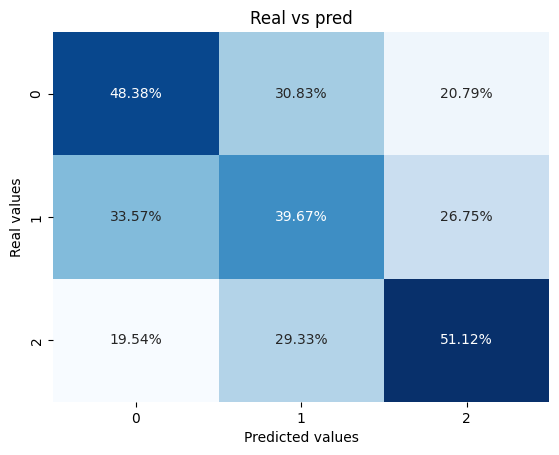

In [255]:
#display_cm(y_test, y_pred_rf_cv)

sns.heatmap(confusion_matrix(y_test,y_pred_lin_svc_cv_tf, normalize = 'true'),
            annot=True,fmt='.2%' ,cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

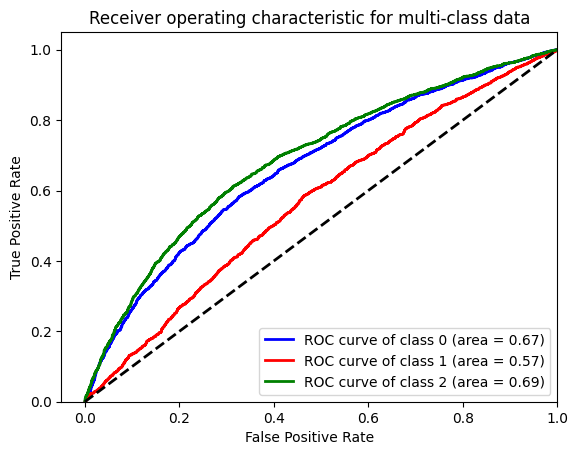

In [256]:
n_classes = 3
y_score = lin_svc_cv_tf.decision_function(X_test_vec_tf)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### GaussianNB

In [257]:
clf_GN_tf = GaussianNB()
clf_GN_tf.fit(X_train_vec_tf.toarray(), y_train)
y_pred_clf_GN_tf = clf_GN_tf.predict(X_test_vec_tf.toarray())

In [258]:
print(classification_report(y_test,y_pred_clf_GN_tf))

              precision    recall  f1-score   support

          -1       0.50      0.27      0.35      2939
           0       0.30      0.27      0.28      1966
           1       0.38      0.65      0.48      2359

    accuracy                           0.39      7264
   macro avg       0.40      0.39      0.37      7264
weighted avg       0.41      0.39      0.38      7264



In [259]:
tfc_GaussianNb = ['GaussianNB','TfidfVectorizer',accuracy_score(y_test, y_pred_clf_GN_tf),f1_score(y_test, y_pred_clf_GN_tf,average='macro'),
                  precision_score(y_test, y_pred_clf_GN_tf,average='macro'),balanced_accuracy_score(y_test, y_pred_clf_GN_tf),
                  roc_auc_score(y_test, clf_GN_tf.predict_proba(X_test_vec_tf.toarray()),multi_class='ovr')]
tfc_GaussianNb

['GaussianNB',
 'TfidfVectorizer',
 0.3909691629955947,
 0.37229023978515235,
 0.3972751273090604,
 0.3940996500738197,
 0.5460811638369248]

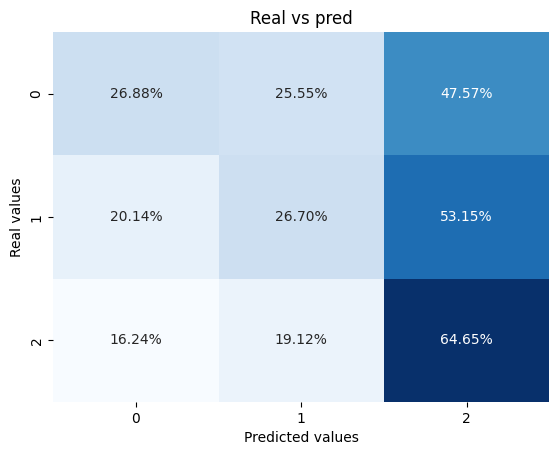

In [260]:
sns.heatmap(confusion_matrix(y_test, y_pred_clf_GN_tf, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
plt.show()

## Métodos de Ensamble

### Random Forest

Barrido de n_estimator = 100 hasta 400 aumentos de 50 
max_depth ---> 2,10 incremtos de 2
min_samples_leaf ----1,2,3
criterion ----> “gini”, “entropy”
class_weight--> “balanced”, “balanced_subsample []

In [261]:
random_forest_cv_tf = RandomForestClassifier(class_weight= 'balanced_subsample',
 criterion= 'gini',
 max_depth= 10,
 min_samples_leaf= 3,
 n_estimators= 350,random_state= 123)
random_forest_cv_tf.fit(X_train_vec_tf, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_leaf=3, n_estimators=350, random_state=123)

In [262]:
y_pred_rf_cv_tf = random_forest_cv_tf.predict(X_test_vec_tf)
print(classification_report(y_test, y_pred_rf_cv_tf))

              precision    recall  f1-score   support

          -1       0.66      0.55      0.60      2939
           0       0.40      0.49      0.44      1966
           1       0.64      0.65      0.64      2359

    accuracy                           0.57      7264
   macro avg       0.57      0.56      0.56      7264
weighted avg       0.58      0.57      0.57      7264



In [263]:
tfc_rf = ['RandomForest','TfidfVectorizer',accuracy_score(y_test, y_pred_rf_cv_tf),f1_score(y_test, y_pred_rf_cv_tf,average='macro'),
                  precision_score(y_test, y_pred_rf_cv_tf,average='macro'),balanced_accuracy_score(y_test, y_pred_rf_cv_tf),
                  roc_auc_score(y_test, random_forest_cv_tf.predict_proba(X_test_vec_tf), multi_class='ovr')]
tfc_rf

['RandomForest',
 'TfidfVectorizer',
 0.567318281938326,
 0.5623942510492251,
 0.5670589233612645,
 0.5643082117553991,
 0.746040060158916]

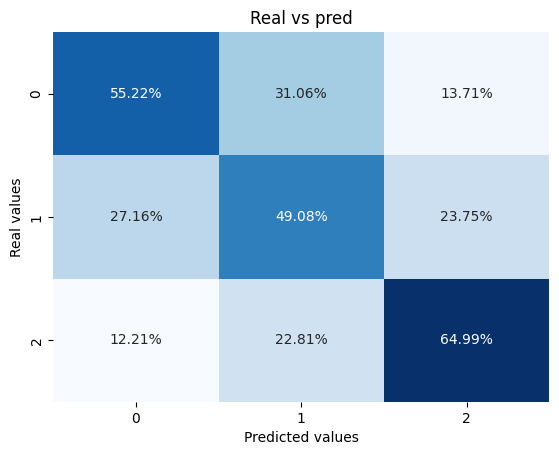

In [264]:
y_pred_rf_cv_tf = random_forest_cv_tf.predict(X_test_vec_tf)
sns.heatmap(confusion_matrix(y_test, y_pred_rf_cv_tf, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
plt.show()

## HistGradientBoostingClassifier

In [265]:
clf_hgb_tf = HistGradientBoostingClassifier()
clf_hgb_tf.fit(X_train_vec_tf.toarray(), y_train)

y_pred_clf_hgb_tf = clf_hgb_tf.predict(X_test_vec_tf.toarray())


In [266]:
print(classification_report(y_test, y_pred_clf_hgb_tf))

              precision    recall  f1-score   support

          -1       0.61      0.60      0.60      2939
           0       0.38      0.45      0.42      1966
           1       0.66      0.57      0.61      2359

    accuracy                           0.55      7264
   macro avg       0.55      0.54      0.54      7264
weighted avg       0.56      0.55      0.56      7264



In [267]:
tfc_HGB = ['HistGradientBoosting','TfidfVectorizer',accuracy_score(y_test, y_pred_lin_svc_cv),f1_score(y_test, y_pred_lin_svc_cv,average='macro'),
                  precision_score(y_test, y_pred_lin_svc_cv,average='macro'),balanced_accuracy_score(y_test, y_pred_lin_svc_cv),
                  roc_auc_score(y_test,clf_GN_tf.predict_proba(X_test_vec_tf.toarray()),multi_class='ovr')]
tfc_HGB

['HistGradientBoosting',
 'TfidfVectorizer',
 0.5088105726872246,
 0.5080345606415225,
 0.5245827058981943,
 0.50682720002851,
 0.5460811638369248]

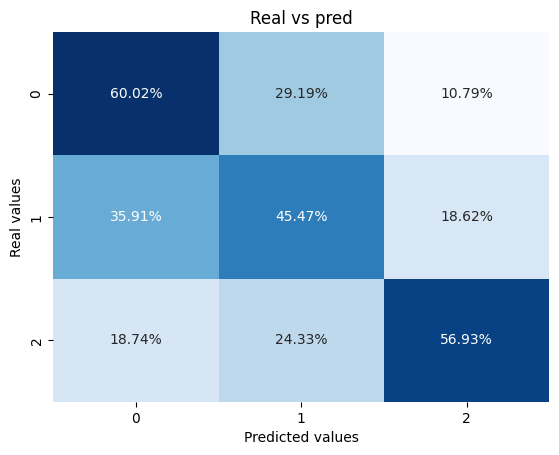

In [268]:
sns.heatmap(confusion_matrix(y_test,y_pred_clf_hgb_tf, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

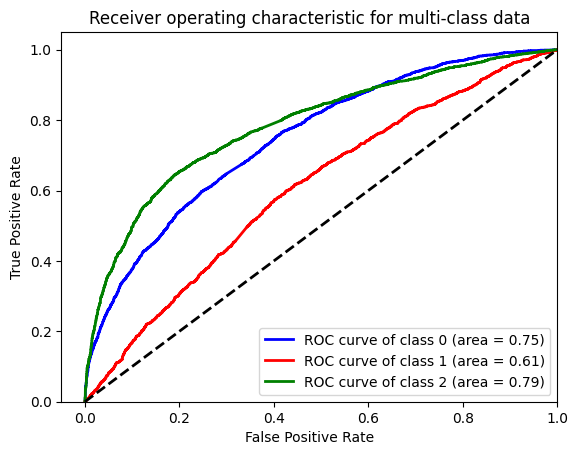

In [269]:
n_classes = 3
y_score = clf_hgb_tf.decision_function(X_test_vec_tf.toarray())
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


### GradientBoostingClassifier

In [270]:
clf_GBC_tf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train_vec_tf, y_train)
y_predict_clf_GBC_tf = clf_GBC_tf.predict(X_test_vec_tf)

In [271]:
print(classification_report(y_test, y_predict_clf_GBC_tf))

              precision    recall  f1-score   support

          -1       0.56      0.68      0.61      2939
           0       0.36      0.31      0.34      1966
           1       0.67      0.57      0.62      2359

    accuracy                           0.54      7264
   macro avg       0.53      0.52      0.52      7264
weighted avg       0.54      0.54      0.54      7264



In [272]:
tfc_GBC = ['GradientBoosting','TfidfVectorizer',accuracy_score(y_test, y_predict_clf_GBC_tf),f1_score(y_test, y_predict_clf_GBC_tf,average='macro'),
                  precision_score(y_test, y_predict_clf_GBC_tf,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_GBC_tf),
                  roc_auc_score(y_test,clf_GBC_tf.predict_proba(X_test_vec_tf),multi_class='ovr')]
tfc_GBC

['GradientBoosting',
 'TfidfVectorizer',
 0.5447411894273128,
 0.5225060824431189,
 0.5318472806234206,
 0.5210154700226104,
 0.7267065320659648]

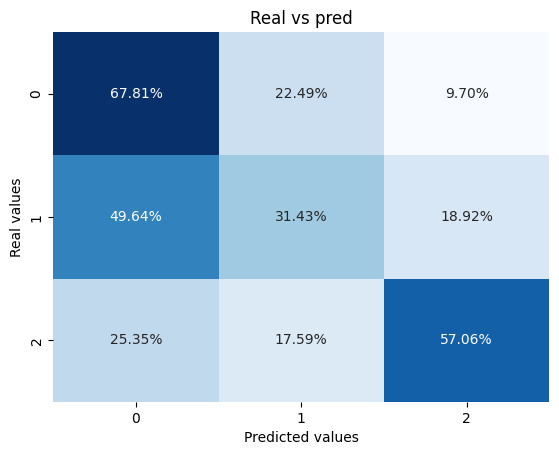

In [273]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_GBC_tf, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

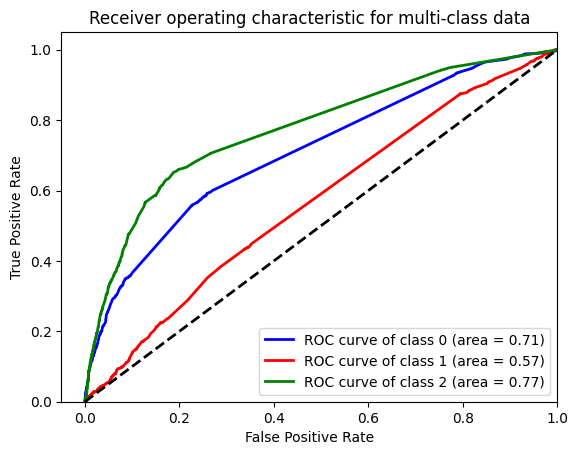

In [274]:
n_classes = 3
y_score = clf_GBC_tf.decision_function(X_test_vec_tf.toarray())
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


### VotingClassifier

In [275]:
eclf2_tf = VotingClassifier(estimators=[
         ('lr', clf_LR_tf ), ('rf', random_forest_cv_tf ), ('HB', clf_hgb_tf)],
         voting='hard')
eclf2_tf = eclf2_tf.fit(X_train_vec_tf.toarray(), y_train)
y_predict_clf_VT_tf = eclf2_tf.predict(X_test_vec_tf.toarray())

In [276]:
print(classification_report(y_test, y_predict_clf_VT_tf))

              precision    recall  f1-score   support

          -1       0.61      0.66      0.64      2939
           0       0.42      0.44      0.43      1966
           1       0.69      0.60      0.64      2359

    accuracy                           0.58      7264
   macro avg       0.58      0.57      0.57      7264
weighted avg       0.59      0.58      0.58      7264



In [277]:
try:
    tfc_VC = ['VotingClassifer','TfidfVectorizer',accuracy_score(y_test, y_predict_clf_VT_tf),f1_score(y_test, y_predict_clf_VT_tf,average='macro'),
                  precision_score(y_test, y_predict_clf_VT_tf,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_VT_tf),
                  roc_auc_score(y_test,eclf2_tf.predict_proba(X_test_vec_tf),multi_class='ovr')]
except:
    tfc_VC = ['VotingClassifer','TfidfVectorizer',accuracy_score(y_test, y_predict_clf_VT_tf),f1_score(y_test, y_predict_clf_VT_tf,average='macro'),
                  precision_score(y_test, y_predict_clf_VT_tf,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_VT_tf),
                  0]
tfc_VC

['VotingClassifer',
 'TfidfVectorizer',
 0.5810848017621145,
 0.5692299508072601,
 0.575581475800305,
 0.5661860338703778,
 0]

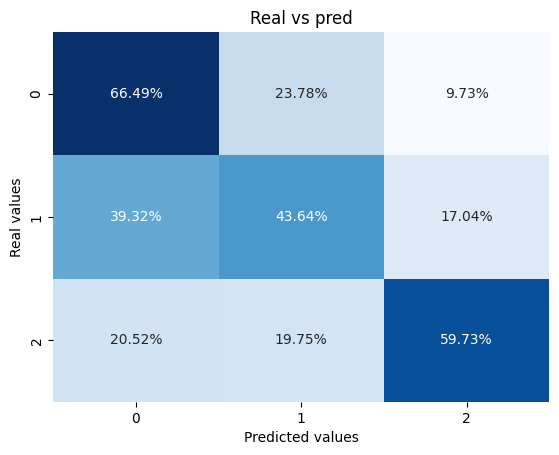

In [278]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_VT_tf, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

### StackingClassifier

In [279]:
estimators_tf = [('lr', LogisticRegression(C = 1.5 , class_weight = None, penalty = 'l2', solver ='newton-cg', random_state=0)),
('rf', RandomForestClassifier(class_weight= 'balanced_subsample',criterion= 'entropy', max_depth= 10, min_samples_leaf= 1, n_estimators= 350,random_state= 123)),
('GB',GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0))]
clf_SC_tf = StackingClassifier(estimators=estimators_tf, final_estimator=LogisticRegression())

In [280]:
clf_SC_tf.fit(X_train_vec_tf, y_train)
y_predict_clf_SC_tf= clf_SC_tf.predict(X_test_vec_tf)

In [281]:
print(classification_report(y_test, y_predict_clf_SC_tf))

              precision    recall  f1-score   support

          -1       0.63      0.68      0.65      2939
           0       0.42      0.41      0.42      1966
           1       0.69      0.63      0.66      2359

    accuracy                           0.59      7264
   macro avg       0.58      0.57      0.58      7264
weighted avg       0.59      0.59      0.59      7264



In [282]:
tfc_StC = ['StackingClassifer','TfidfVectorizer',accuracy_score(y_test, y_predict_clf_SC_tf),f1_score(y_test, y_predict_clf_SC_tf,average='macro'),
                  precision_score(y_test, y_predict_clf_SC_tf,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_SC_tf),
                  roc_auc_score(y_test,clf_SC_tf.predict_proba(X_test_vec_tf),multi_class='ovr')]
tfc_StC

['StackingClassifer',
 'TfidfVectorizer',
 0.5914096916299559,
 0.5760790426878278,
 0.5789680492669916,
 0.5744240479600754,
 0.7663221668602415]

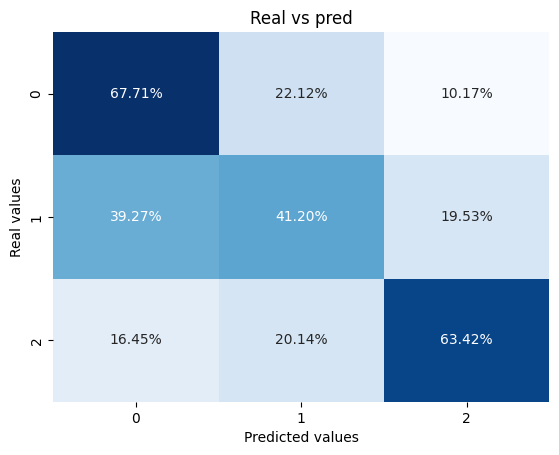

In [283]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_SC_tf, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

### XGrandient Boosting

In [284]:
xgbr_clf_tf = xgb.XGBClassifier(booster = 'dart', eta = 0.5, gamma = 0.9 , learning_rate= 0.05,seed = 20)
xgbr_clf_tf.fit(X_train_vec_tf, y_train_xgbr)
y_clf_xgbr_tf = xgbr_clf_tf.predict(X_test_vec_tf)

In [285]:
print(classification_report(y_test_xgbr, y_clf_xgbr_tf))

              precision    recall  f1-score   support

           0       0.52      0.77      0.62      2939
           1       0.38      0.25      0.30      1966
           2       0.72      0.50      0.59      2359

    accuracy                           0.54      7264
   macro avg       0.54      0.51      0.51      7264
weighted avg       0.55      0.54      0.53      7264



In [286]:
tfc_Xgbrt = ['XGBClassifier','TfidfVectorizer',accuracy_score(y_test_xgbr, y_clf_xgbr_tf),f1_score(y_test_xgbr, y_clf_xgbr_tf,average='macro'),
          precision_score(y_test_xgbr, y_clf_xgbr_tf,average='macro'),balanced_accuracy_score(y_test_xgbr, y_clf_xgbr_tf),
          roc_auc_score(y_test_xgbr, xgbr_clf_tf.predict_proba(X_test_vec_tf),multi_class='ovr')]
tfc_Xgbrt

['XGBClassifier',
 'TfidfVectorizer',
 0.5430892070484582,
 0.5063544191807517,
 0.5421995976056108,
 0.5082610462753402,
 0.7227611135195015]

# Abordemos los emmbedings 

In [287]:

import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/nnlm-es-dim128/2")
X_train_embeddings = embed(X_train)
X_test_embeddings = embed(X_test)


## Algoritmos Clásicos de clasificación

### Regresión Logistica

In [288]:
clf_LR_emb = LogisticRegression(C = 0.25 , class_weight = None, penalty = 'l2', solver ='newton-cg', random_state=0).fit(X_train_embeddings, y_train)
y_pred_log_reg_cv_proba_emb = clf_LR_emb.predict_proba(X_test_embeddings)
y_pred_log_reg_cv_emb = clf_LR_emb.predict(X_test_embeddings)

In [289]:
def get_label(probas, i=0.55):
    if np.argmax(probas)==0:
        return -1
    elif np.argmax(probas)==2:
        return 1
    elif np.argmax(probas)==1 and probas[1]<i:
        if probas[2] > probas[0]:
            return 1
        else:
            return -1
    else:
        return 0

y_new = np.array(list(map(lambda x: get_label(x), y_pred_log_reg_cv_proba_emb)))

def interact_proba(i):
    plt.clf()
    
    y_new = np.array(list(map(lambda x: get_label(x, i), y_pred_log_reg_cv_proba_emb)))
    
    # Evaluamos modelo
    sns.heatmap(confusion_matrix(y_test, y_new, normalize = 'true'),
                annot=True, fmt='g', cmap = 'Blues', cbar = False);

    plt.title("""Accuracy para cada clase en función
    del threshold controlado por el parámetro i""")
    plt.xlabel('Predicted values')
    plt.ylabel('Real values');

    plt.show()

In [290]:
emb_lr = ['LogisticRegresion','Embedding',accuracy_score(y_test, y_pred_log_reg_cv_emb),f1_score(y_test, y_pred_log_reg_cv_emb,average='macro'),
                  precision_score(y_test, y_pred_log_reg_cv_emb,average='macro'),balanced_accuracy_score(y_test, y_pred_log_reg_cv_emb),
                  roc_auc_score(y_test,clf_LR_emb.predict_proba(X_test_embeddings),multi_class='ovr')]
emb_lr

['LogisticRegresion',
 'Embedding',
 0.5988436123348018,
 0.5857708246089194,
 0.5892774284480846,
 0.583780662997155,
 0.769020655772386]

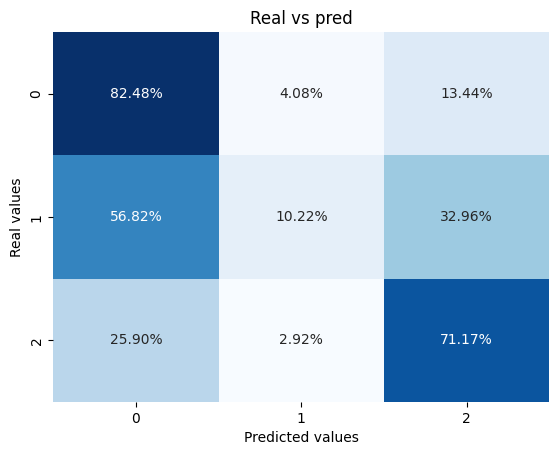

In [291]:
# Evaluamos modelo
sns.heatmap(confusion_matrix(y_test, y_new, normalize = 'true'),
            annot=True,fmt='.2%', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

In [292]:
print(classification_report(y_test, y_pred_log_reg_cv_emb))

              precision    recall  f1-score   support

          -1       0.64      0.68      0.66      2939
           0       0.44      0.45      0.44      1966
           1       0.69      0.62      0.65      2359

    accuracy                           0.60      7264
   macro avg       0.59      0.58      0.59      7264
weighted avg       0.60      0.60      0.60      7264



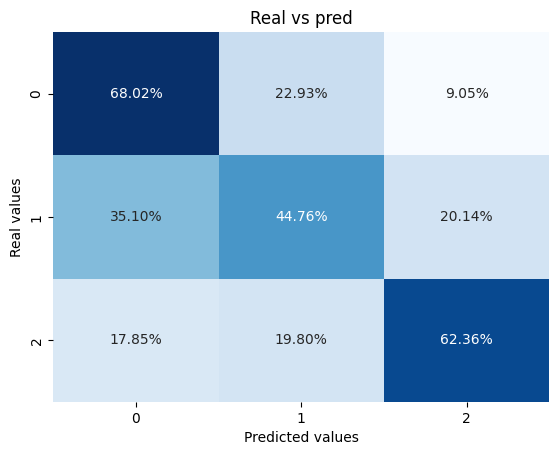

In [293]:
# Evaluamos modelo
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg_cv_emb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

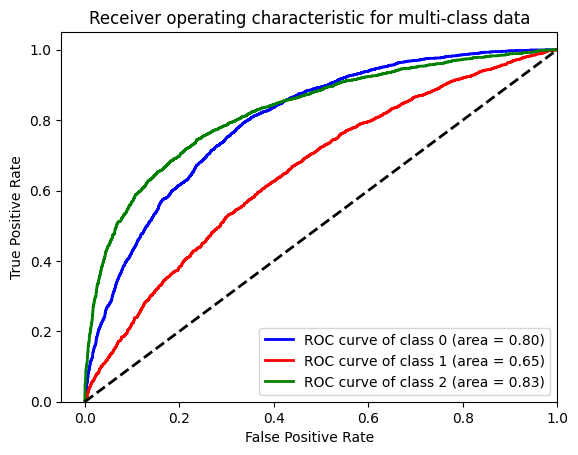

In [294]:
# Compute ROC curve and ROC area for each class
n_classes = 3
y_score = clf_LR_emb.decision_function(X_test_embeddings)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### SVC

In [295]:
pipe_lin_svc_emb = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('svc', SVC(kernel='linear',probability=True))
])
pipe_lin_svc_params = dict(svc__C = [0.01, 0.1, 0.25, 0.5, 1, 1.5])

lin_svc_cv_emb = GridSearchCV(pipe_lin_svc_emb,
                          pipe_lin_svc_params,
                          cv = 10,
                          n_jobs = -1,
                          scoring = 'f1')
lin_svc_cv_emb.fit(np.array(X_train_embeddings), y_train)
lin_svc_cv_emb.best_params_
y_pred_lin_svc_cv_emb = lin_svc_cv_emb.predict(X_test_embeddings)


In [296]:
emb_svc_lineal = ['LinearSVC','Embedding',accuracy_score(y_test, y_pred_lin_svc_cv_emb),f1_score(y_test, y_pred_lin_svc_cv_emb,average='macro'),
                  precision_score(y_test, y_pred_lin_svc_cv_emb,average='macro'),balanced_accuracy_score(y_test, y_pred_lin_svc_cv_emb),
                  0]
emb_svc_lineal

['LinearSVC',
 'Embedding',
 0.5912720264317181,
 0.5807928001340549,
 0.5868958097363977,
 0.578085882630711,
 0]

In [297]:
# Sacamos matriz de correlación
print(classification_report(y_test, y_pred_lin_svc_cv_emb))

              precision    recall  f1-score   support

          -1       0.64      0.67      0.66      2939
           0       0.42      0.47      0.44      1966
           1       0.70      0.60      0.65      2359

    accuracy                           0.59      7264
   macro avg       0.59      0.58      0.58      7264
weighted avg       0.60      0.59      0.59      7264



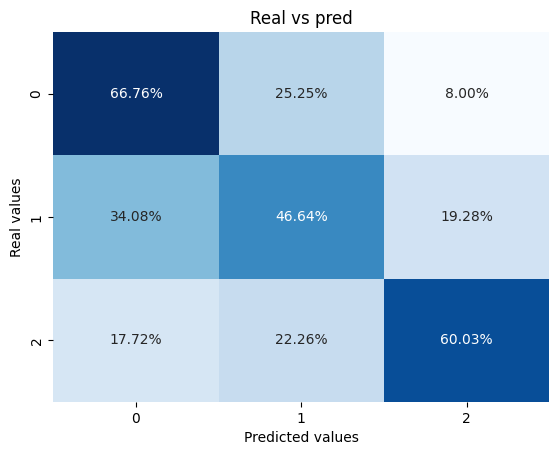

In [298]:
#display_cm(y_test, y_pred_rf_cv)

sns.heatmap(confusion_matrix(y_test,y_pred_lin_svc_cv_emb, normalize = 'true'),
            annot=True,fmt='.2%' ,cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

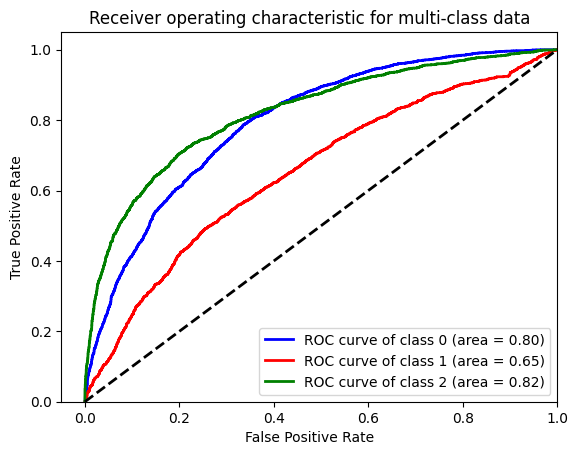

In [299]:
n_classes = 3
y_score = lin_svc_cv_emb.decision_function(X_test_embeddings)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### GaussianNB

In [300]:
clf_GN_emb = GaussianNB()
clf_GN_emb.fit(X_train_embeddings, y_train)
y_pred_clf_GN_emb = clf_GN_emb.predict(X_test_embeddings)

In [301]:
print(classification_report(y_test,y_pred_clf_GN_emb))

              precision    recall  f1-score   support

          -1       0.63      0.61      0.62      2939
           0       0.40      0.41      0.40      1966
           1       0.63      0.66      0.64      2359

    accuracy                           0.57      7264
   macro avg       0.55      0.56      0.55      7264
weighted avg       0.57      0.57      0.57      7264



In [302]:
emb_GaussianNB = ['GaussianNB','Embedding',accuracy_score(y_test, y_pred_clf_GN_emb),f1_score(y_test, y_pred_clf_GN_emb,average='macro'),
                  precision_score(y_test, y_pred_clf_GN_emb,average='macro'),balanced_accuracy_score(y_test, y_pred_clf_GN_emb),
                  roc_auc_score(y_test,clf_GN_emb.predict_proba(X_test_embeddings),multi_class='ovr')]
emb_GaussianNB

['GaussianNB',
 'Embedding',
 0.5682819383259912,
 0.5549267670015594,
 0.5541817959908536,
 0.5560902839284237,
 0.744888166648629]

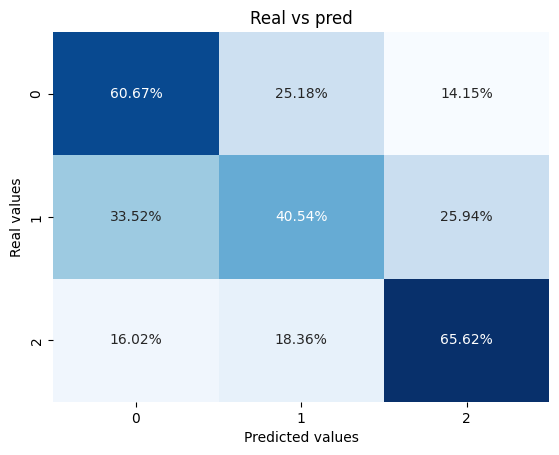

In [303]:
sns.heatmap(confusion_matrix(y_test, y_pred_clf_GN_emb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
plt.show()

## Métodos de Ensamble

### Random Forest

Barrido de n_estimator = 100 hasta 400 aumentos de 50 
max_depth ---> 2,10 incremtos de 2
min_samples_leaf ----1,2,3
criterion ----> “gini”, “entropy”
class_weight--> “balanced”, “balanced_subsample []

In [304]:
random_forest_cv_emb = RandomForestClassifier(class_weight= 'balanced_subsample',
 criterion= 'entropy',
 max_depth= 10,
 min_samples_leaf= 1,
 n_estimators= 350,random_state= 123)
random_forest_cv_emb.fit(X_train_embeddings, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, n_estimators=350, random_state=123)

In [305]:
y_pred_rf_cv_emb = random_forest_cv_emb.predict(X_test_embeddings)
print(classification_report(y_test, y_pred_rf_cv_emb))

              precision    recall  f1-score   support

          -1       0.61      0.71      0.66      2939
           0       0.43      0.35      0.39      1966
           1       0.65      0.62      0.64      2359

    accuracy                           0.58      7264
   macro avg       0.56      0.56      0.56      7264
weighted avg       0.58      0.58      0.58      7264



In [306]:
emb_rf = ['RandomForest','Embedding',accuracy_score(y_test, y_pred_rf_cv_emb ),f1_score(y_test, y_pred_rf_cv_emb ,average='macro'),
                  precision_score(y_test, y_pred_rf_cv_emb ,average='macro'),balanced_accuracy_score(y_test, y_pred_rf_cv_emb ),
                  roc_auc_score(y_test,random_forest_cv_emb.predict_proba(X_test_embeddings),multi_class='ovr')]
emb_rf

['RandomForest',
 'Embedding',
 0.583012114537445,
 0.5591726550030237,
 0.5641166027753265,
 0.5597104962099043,
 0.7512219004520321]

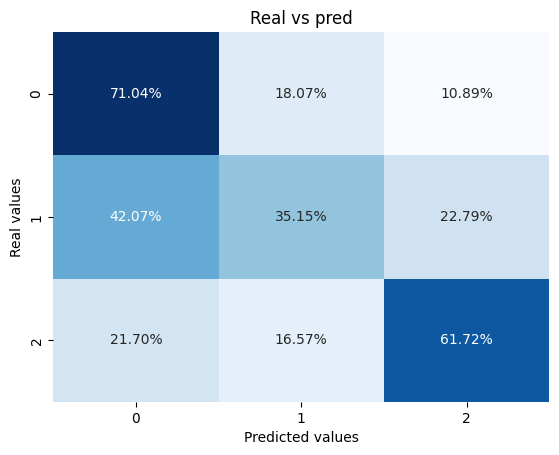

In [307]:
sns.heatmap(confusion_matrix(y_test,y_pred_rf_cv_emb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
plt.show()

## HistGradientBoostingClassifier

In [308]:
clf_hgb_emb = HistGradientBoostingClassifier()
clf_hgb_emb.fit(X_train_embeddings, y_train)

y_pred_clf_hgb_emb = clf_hgb_emb.predict(X_test_embeddings)


In [309]:
emb_HGB = ['HistGradiantBoosting','Embedding',accuracy_score(y_test, y_pred_clf_hgb_emb),f1_score(y_test, y_pred_clf_hgb_emb,average='macro'),
                  precision_score(y_test, y_pred_clf_hgb_emb,average='macro'),balanced_accuracy_score(y_test, y_pred_clf_hgb_emb),
                  roc_auc_score(y_test,clf_hgb_emb.predict_proba(X_test_embeddings),multi_class='ovr')]
emb_HGB

['HistGradiantBoosting',
 'Embedding',
 0.5664922907488987,
 0.5522447944441955,
 0.5575005254719579,
 0.5498800043447677,
 0.7469637170311832]

In [310]:
print(classification_report(y_test, y_pred_clf_hgb_emb))

              precision    recall  f1-score   support

          -1       0.61      0.66      0.64      2939
           0       0.40      0.41      0.41      1966
           1       0.66      0.57      0.61      2359

    accuracy                           0.57      7264
   macro avg       0.56      0.55      0.55      7264
weighted avg       0.57      0.57      0.57      7264



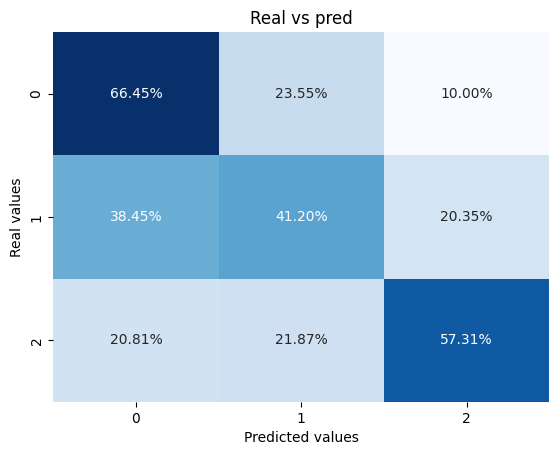

In [311]:
sns.heatmap(confusion_matrix(y_test,y_pred_clf_hgb_emb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

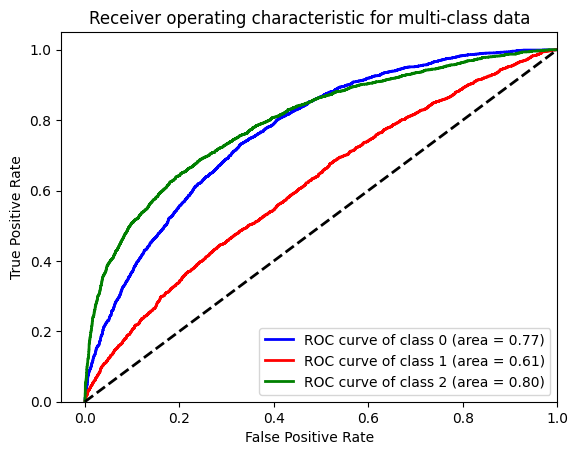

In [312]:
n_classes = 3
y_score = clf_hgb_emb.decision_function(X_test_embeddings)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


### Gradiant Boosting Classifer

In [313]:
clf_GBC_emb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train_embeddings, y_train)
y_predict_clf_GBC_emb = clf_GBC_emb.predict(X_test_embeddings)

In [314]:
emb_GBC = ['GradientBoosting','Embedding',accuracy_score(y_test, y_predict_clf_GBC_emb),f1_score(y_test, y_predict_clf_GBC_emb,average='macro'),
                  precision_score(y_test, y_predict_clf_GBC_emb,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_GBC_emb),
                  roc_auc_score(y_test,clf_GBC_emb.predict_proba(X_test_embeddings),multi_class='ovr')]
emb_GBC

['GradientBoosting',
 'Embedding',
 0.5596090308370044,
 0.5481338085354562,
 0.5531390968819084,
 0.5457261407050155,
 0.7355301891940277]

In [315]:
print(classification_report(y_test, y_predict_clf_GBC_emb))

              precision    recall  f1-score   support

          -1       0.61      0.64      0.63      2939
           0       0.39      0.43      0.41      1966
           1       0.65      0.57      0.61      2359

    accuracy                           0.56      7264
   macro avg       0.55      0.55      0.55      7264
weighted avg       0.57      0.56      0.56      7264



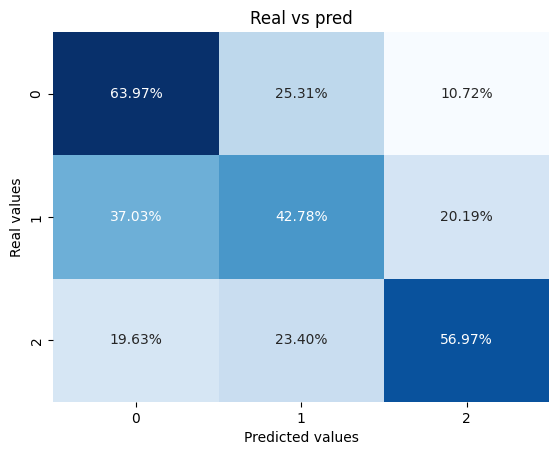

In [316]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_GBC_emb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

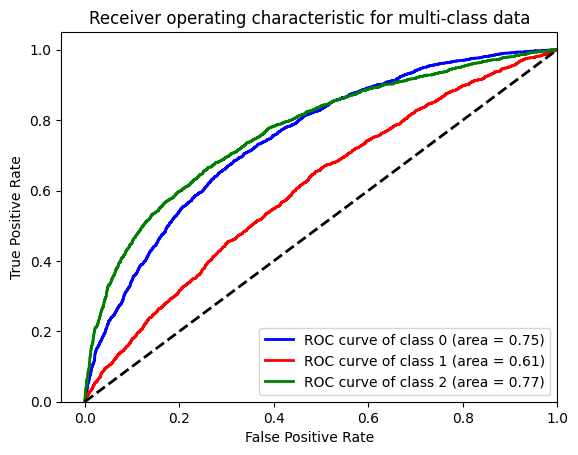

In [317]:
n_classes = 3
y_score = clf_GBC_emb.decision_function(X_test_embeddings)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


### VotingClassifier

In [318]:
eclf2_emb = VotingClassifier(estimators=[
         ('lr', clf_LR_emb ), ('SVC_Lineal',lin_svc_cv_emb) ],
         voting='soft')
eclf2_emb = eclf2_emb.fit(X_train_embeddings.numpy(), y_train)
y_predict_clf_VT_emb= eclf2_emb.predict(X_test_embeddings.numpy())

In [319]:
emb_VT = ['VotingClassfier','Embedding',accuracy_score(y_test, y_predict_clf_VT_emb),f1_score(y_test, y_predict_clf_VT_emb,average='macro'),
                  precision_score(y_test, y_predict_clf_VT_emb,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_VT_emb),
                  roc_auc_score(y_test,eclf2_emb.predict_proba(X_test_embeddings.numpy()),multi_class='ovr')]
emb_VT

['VotingClassfier',
 'Embedding',
 0.5978799559471366,
 0.5841621969590481,
 0.5876903134046598,
 0.5821730122868348,
 0.7679137239773718]

In [320]:
print(classification_report(y_test, y_predict_clf_VT_emb))

              precision    recall  f1-score   support

          -1       0.64      0.68      0.66      2939
           0       0.43      0.44      0.44      1966
           1       0.69      0.62      0.65      2359

    accuracy                           0.60      7264
   macro avg       0.59      0.58      0.58      7264
weighted avg       0.60      0.60      0.60      7264



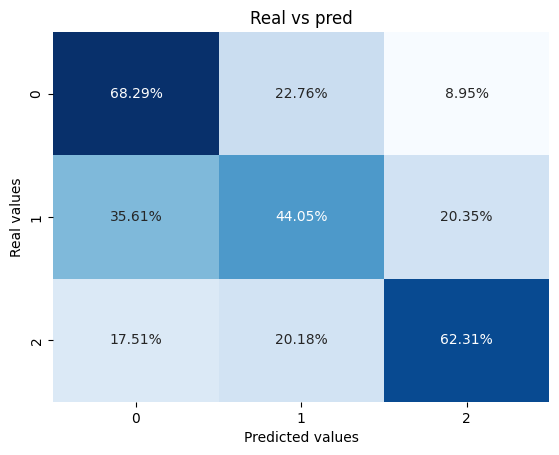

In [321]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_VT_emb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

### StackingClassifier

In [322]:
estimators = [('lr', LogisticRegression(C = 1.5 , class_weight = None, penalty = 'l2', solver ='newton-cg', random_state=0)),
('rf', RandomForestClassifier(class_weight= 'balanced_subsample',criterion= 'entropy', max_depth= 10, min_samples_leaf= 1, n_estimators= 350,random_state= 123)),
('GB',GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0))]
clf_SC_emb = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier())

In [323]:
clf_SC_emb.fit(X_train_embeddings.numpy(), y_train)
y_predict_clf_SC_emb= clf_SC_emb.predict(X_test_embeddings.numpy())

In [324]:
emb_StC = ['StackingClassifer','Embedding',accuracy_score(y_test, y_predict_clf_SC_emb),f1_score(y_test, y_predict_clf_SC_emb,average='macro'),
                  precision_score(y_test, y_predict_clf_SC_emb,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_SC_emb),
                  roc_auc_score(y_test,clf_SC_emb.predict_proba(X_test_embeddings.numpy()),multi_class='ovr')]
emb_StC

['StackingClassifer',
 'Embedding',
 0.5849394273127754,
 0.5722996216994866,
 0.577611203426358,
 0.5696112446060849,
 0.7453468331307085]

In [325]:
print(classification_report(y_test, y_predict_clf_SC_emb))

              precision    recall  f1-score   support

          -1       0.62      0.67      0.64      2939
           0       0.42      0.43      0.43      1966
           1       0.69      0.60      0.64      2359

    accuracy                           0.58      7264
   macro avg       0.58      0.57      0.57      7264
weighted avg       0.59      0.58      0.59      7264



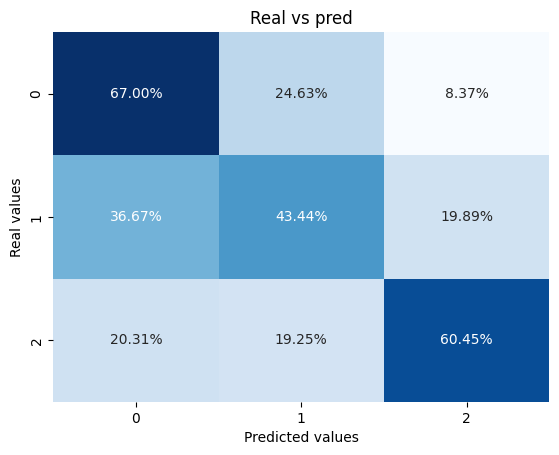

In [326]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_SC_emb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

### XGrandient Boosting

In [327]:
xgbr_clf_emb = xgb.XGBClassifier(booster = 'dart', eta = 0.5, gamma = 0.3 , learning_rate= 0.05,seed = 20)
xgbr_clf_emb.fit(X_train_embeddings.numpy(), y_train_xgbr)
y_clf_xgbr_emb = xgbr_clf_emb.predict(X_test_embeddings.numpy())

In [328]:
print(classification_report(y_test_xgbr, y_clf_xgbr_emb))

              precision    recall  f1-score   support

           0       0.61      0.70      0.65      2939
           1       0.43      0.41      0.42      1966
           2       0.68      0.57      0.62      2359

    accuracy                           0.58      7264
   macro avg       0.57      0.56      0.56      7264
weighted avg       0.58      0.58      0.58      7264



In [329]:
emb_Xgbrt = ['XGBClassifier','Embeding',accuracy_score(y_test_xgbr, y_clf_xgbr_emb),f1_score(y_test_xgbr, y_clf_xgbr_emb,average='macro'),
          precision_score(y_test_xgbr, y_clf_xgbr_emb,average='macro'),balanced_accuracy_score(y_test_xgbr, y_clf_xgbr_emb),
          roc_auc_score(y_test_xgbr, xgbr_clf_emb.predict_proba(X_test_embeddings),multi_class='ovr')]
emb_Xgbrt

['XGBClassifier',
 'Embeding',
 0.5799834801762115,
 0.5633248461069976,
 0.5717255326383142,
 0.5606877943453606,
 0.7487385837440282]

## Resultados

In [330]:
ideal =['Ideal','Ideal',1,1,1,1,1]
todas_las_medidas = [ideal,ct_lr,ct_svc_lineal,ct_GauNB,ct_rf,ct_HBG,ct_GBc,ct_VC,ct_StC,ct_Xgbrt,
                     tfc_lr,tfc_scv_lineal,tfc_GaussianNb,tfc_rf,tfc_HGB,tfc_GBC,tfc_StC,tfc_Xgbrt,
                     emb_lr,emb_svc_lineal,emb_GaussianNB,emb_rf,emb_HGB,emb_GBC,emb_VT, emb_StC,emb_Xgbrt]
df_resultados = pd.DataFrame(todas_las_medidas,columns=['Model','Vectorizacion','Accuracy','F1','Presicion','Balanced Accurracy', 'ROC AUC'])
df_resultados = df_resultados.sort_values(by = 'Accuracy',ascending= False)
df_resultados['Categoria'] = df_resultados['Model']+'_' +df_resultados['Vectorizacion']
df_resultados_ = df_resultados[['Accuracy', 'F1', 'Presicion',
       'Balanced Accurracy', 'ROC AUC', 'Categoria']]
df_resultados_ = df_resultados_.set_index('Categoria') 
df_resultados_stack = df_resultados_.stack()
df_resultados_stack
df_resultados_stack_final = df_resultados_stack.reset_index()

In [331]:
df_resultados

,Model,Vectorizacion,Accuracy,F1,Presicion,Balanced Accurracy,ROC AUC,Categoria
0,Ideal,Ideal,1.000000,1.000000,1.000000,1.000000,1.000000,Ideal_Ideal
18,LogisticRegresion,Embedding,0.598844,0.585771,0.589277,0.583781,0.769021,LogisticRegresion_Embedding
24,VotingClassfier,Embedding,0.597880,0.584162,0.587690,0.582173,0.767914,VotingClassfier_Embedding
8,StackingClassifier,CountVectorizer,0.591547,0.578798,0.583835,0.576117,0.767448,StackingClassifier_CountVectorizer
16,StackingClassifer,TfidfVectorizer,0.591410,0.576079,0.578968,0.574424,0.766322,StackingClassifer_TfidfVectorizer
19,LinearSVC,Embedding,0.591272,0.580793,0.586896,0.578086,0.000000,LinearSVC_Embedding
1,regresion_logistica,CountVectorizer,0.585215,0.576061,0.581907,0.573459,0.758290,regresion_logistica_CountVectorizer
25,StackingClassifer,Embedding,0.584939,0.572300,0.577611,0.569611,0.745347,StackingClassifer_Embedding
10,LogisticRegression,TfidfVectorizer,0.584939,0.560677,0.579668,0.558261,0.757493,LogisticRegression_TfidfVectorizer
21,RandomForest,Embedding,0.583012,0.559173,0.564117,0.559710,0.751222,RandomForest_Embedding


In [332]:
polar_fig = px.line_polar(df_resultados_stack_final, r=0, theta='level_1',color='Categoria',range_r=[0,1.2],width=1200, height=1200)
polar_fig.show()

# Redes Neuronales


In [333]:
df_initial['Dataset'] = 'Train'
df_final['Dataset'] = 'Test'
df = pd.concat([df_initial,df_final])

In [334]:
from tensorflow import keras


# Número de palabras del modelo
tokens = set()
for tweet in df.tweet_:
    for word in tweet.split():
        tokens.add(word)
dim = len(tokens)        
print('Número total de palabras:', dim)
        

Número total de palabras: 13654


In [335]:
INPUT_LENGTH = 25
EMBED_DIM = 128
MAX_LEN = 250

# Creamos tokenizador
tokenizer = keras.preprocessing.text.Tokenizer(num_words = dim)
tokenizer.fit_on_texts(df_initial.tweet_)
sequences = tokenizer.texts_to_sequences(df_initial.tweet_)
X = keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen = INPUT_LENGTH

)
y_ = pd.get_dummies(df_initial.classification).values


In [336]:
len(X[0])

25

In [337]:
# Separamos train/test
from sklearn.model_selection import train_test_split
x_train_, x_test_, y_train_, y_test_ = train_test_split(X, y_,
                                                    random_state = 42,
                                                    test_size = 0.45)

In [338]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

# Definimos parámetros para el modelo
DROPOUT_VAL = 0.3
BATCH_SIZE = 16
EPOCHS = 5

# Creamos capas

layers = [
    keras.layers.Embedding(dim, 20, input_length = INPUT_LENGTH),
    keras.layers.Conv1D(64,5),
    keras.layers.Conv1D(32,3),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(140,dropout = DROPOUT_VAL, return_sequences=True),
    keras.layers.LSTM(140,dropout = DROPOUT_VAL),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(3, activation = 'softmax')   
]

model = keras.models.Sequential(layers)

# Compilamos

model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
                            

In [339]:
# Entrenamos

history_2 = model.fit(x_train_,
                       y_train_,
                       epochs = EPOCHS,
                       validation_data = (x_test_, y_test_),
                       batch_size = 16)

Epoch 1/5
249/249 [==============================] - 8s 20ms/step - loss: 1.0439 - accuracy: 0.4542 - val_loss: 1.0478 - val_accuracy: 0.4374
Epoch 2/5
249/249 [==============================] - 4s 18ms/step - loss: 0.7857 - accuracy: 0.6518 - val_loss: 0.9681 - val_accuracy: 0.5169
Epoch 3/5
249/249 [==============================] - 5s 18ms/step - loss: 0.4716 - accuracy: 0.8162 - val_loss: 1.2229 - val_accuracy: 0.5129
Epoch 4/5
249/249 [==============================] - 5s 18ms/step - loss: 0.2391 - accuracy: 0.9141 - val_loss: 1.7783 - val_accuracy: 0.4975
Epoch 5/5
249/249 [==============================] - 5s 18ms/step - loss: 0.1442 - accuracy: 0.9498 - val_loss: 1.8837 - val_accuracy: 0.4880


In [340]:
# Evaluamos
accuracy_dl_lstm = model.evaluate(x_test_, y_test_)
accuracy_dl_lstm

102/102 [==============================] - 1s 6ms/step - loss: 1.8837 - accuracy: 0.4880


[1.8837488889694214, 0.4880368113517761]

In [341]:

# Sacamos classification report
y_pred_2 = model.predict(x_test_)
print(classification_report(np.argmax(y_test_, axis=1), np.argmax(y_pred_2, axis=1)))

102/102 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.54      0.59      0.56      1299
           1       0.38      0.42      0.40      1049
           2       0.56      0.43      0.48       912

    accuracy                           0.49      3260
   macro avg       0.49      0.48      0.48      3260
weighted avg       0.49      0.49      0.49      3260



# Pysentimiento 

In [342]:
from pysentimiento import SentimentAnalyzer
analyzer = SentimentAnalyzer(lang="es")

In [343]:
from pysentimiento.preprocessing import preprocess_tweet

In [344]:
tweet_2 = []
for i in range(df_initial.shape[0]):
    tweet_2.append(preprocess_tweet(df_initial.tweet[i:i+1]))
df_initial['tweet_2'] = tweet_2

In [345]:
tweet_2_pred = []
for i in range(df_final.shape[0]):
    tweet_2_pred.append(preprocess_tweet(df_final.tweet[i:i+1]))
df_final['tweet_2'] = tweet_2_pred

In [346]:
X_train_pysen, y_train = df_initial['tweet_2'], df_initial['classification']
X_test_pysen, y_test = df_final['tweet_2'], df_final['classification']
y_test_binarize = label_binarize(y_test,classes=[-1,0,1])
# Vectorizamos
from sklearn.feature_extraction.text import CountVectorizer

# Creamos objeto y entrenamos
df_vectorizer_2 = CountVectorizer(binary = True,
                                      ngram_range=(1, 3))
df_vectorizer_2.fit(X_train_pysen)

# Transformamos X en sparse vector
X_train_pysen_vec = df_vectorizer_2.transform(X_train_pysen)
X_test_pysen_vec = df_vectorizer_2.transform(X_test_pysen)

In [347]:
# Creamos modelo
lr_cv_params = dict(C = np.arange(0.25,2.25,0.25),
                    class_weight = [None, 'balanced'],
                    solver = ['newton-cg', 'sag', 'lbfgs'])

lr_cv_grid = GridSearchCV(LogisticRegression(max_iter = 300),
                     lr_cv_params,
                     cv = 5,
                     n_jobs = -1,
                     scoring = 'f1').fit(X_train_pysen_vec,
                                               y_train)
print('Best score:', lr_cv_grid.best_score_)
print('Best params:', lr_cv_grid.best_params_)

Best score: nan
Best params: {'C': 0.25, 'class_weight': None, 'solver': 'newton-cg'}


In [348]:
clf_LR_pysen = LogisticRegression(C =0.50,solver= 'newton-cg', random_state=1234).fit(X_train_pysen_vec, y_train)
y_pred_log_reg_cv_2 = clf_LR_pysen.predict(X_test_pysen_vec)

In [349]:
print(classification_report(y_test,y_pred_log_reg_cv_2))

              precision    recall  f1-score   support

          -1       0.64      0.67      0.65      2939
           0       0.41      0.44      0.43      1966
           1       0.67      0.58      0.62      2359

    accuracy                           0.58      7264
   macro avg       0.57      0.57      0.57      7264
weighted avg       0.59      0.58      0.58      7264



In [350]:
X_train_embeddings_py = embed(X_train_pysen)
X_test_embeddings_py = embed(X_test_pysen)

In [351]:
clf_LR_pysen = LogisticRegression( random_state=0).fit(X_train_embeddings, y_train)
y_pred_log_reg_cv_2 = clf_LR_pysen.predict(X_test_embeddings_py)

In [352]:
print(classification_report(y_test,y_pred_log_reg_cv_2))

              precision    recall  f1-score   support

          -1       0.66      0.49      0.56      2939
           0       0.37      0.55      0.44      1966
           1       0.56      0.51      0.53      2359

    accuracy                           0.51      7264
   macro avg       0.53      0.52      0.51      7264
weighted avg       0.55      0.51      0.52      7264

